# Desenvolvimento biblioteca PyNILM
---

Visando otimizar os trabalhos da pesquisa, potencializando reprodutibilidade e teste de hipóteses, principalmente no âmbito de avaliar a generalização dos modelos, este notebook contempla o desenvolvimento do pacote PyNILM, que visa:

1. Garantir uma biblioteca padrão para o desenvolvimento da pesquisa;
2. Otimizar a modelagem, tânto no âmbito das arquiteturas de DL quanto no pré-processamento de dados.

Para tal, a bilbioteca PyNILM está estruturada da seguinte forma:

    PyNILM/
        __init__.py
        dados/
            __init__.py
            janelas.py
            graficorecorrencia.py
        modelos/
            __init__.py
            EM_DESENVOLVIMENTO
        avaliacao/
            __init__.py
            metricas.py
            graficos.py
            analise.py

In [1]:
import os
from pprint import pprint
import warnings
warnings.filterwarnings(action="ignore")

# Recarregar bibliotecas ao instancia-las (sem reiniciar kernell)
%load_ext autoreload

# PyNILM

## Submódulo *`dados`*
---

**IMPORTANTE:** o submódulo dados irá assumir datasets dispostos no pacote [NILMTK](https://github.com/nilmtk/nilmtk) para todos os processamentos em suas rotinas.

In [2]:
# Exemplo de carregamento da base REDD no NILMTK
from nilmtk import DataSet
from nilmtk.utils import print_dict

from nilmtk.dataset_converters import convert_redd


# Path do arquivo H5 (base REDD ja preparada p/ NILMTK)
caminho_dataset = "D:/Projetos/phd-thesis/datasets/REDD/low_freq"

# Gerar arquivo H5 (Nilmtk) do dataset REDD, caso n exista
arquivo_dataset = os.path.join(caminho_dataset, "redd.h5")
if not os.path.isfile(arquivo_dataset):
    print("Gerando arquivo H5 (NILMTK) da base REDD, aguarde...")
    print("-----")
    convert_redd(caminho_dataset, arquivo_dataset)

# Carregando dataset REDD no objeto NILMTK
redd = DataSet(arquivo_dataset)
print("NILMTK -> Detalhes sobre o dataset REDD:")
print_dict(redd.metadata)

# VARIAVEL AUXILIAR
# Path dos arquivos relacionados as janelas
caminho_janelas = os.path.join(caminho_dataset, "../../phd")
if not os.path.isdir(caminho_janelas):
    os.makedirs(caminho_janelas)

NILMTK -> Detalhes sobre o dataset REDD:


### Arquivo `janelas.py`
---
O arquivo janelas irá fazer o processamento inicial dos dados, transformando a série temporal de medições de cada carga em subséries de tamanho fixo representando uma janela de amostragem (eg. 30 segundos de medições). 

In [7]:
import numpy as np
from matplotlib import pyplot as plt

class Janelas:
    def __init__(self, base=None, id_residencia=None, inicio_intervalo=None, 
                 fim_intervalo=None, debug=True):
        """
        Args:
            - base (nilmtk.dataset.DataSet): base de dados que será utilizada
                no processaento das janelas;
            - id_residencia (int): indice (1..N) da residencia que terão suas 
                medições processadas em janelas (para consultar a lista de 
                indices disponíveis basta acessar `BASE.buildings`;
            - inicio_intervalo (str): data / hora inicial da faixa de análise 
                dos dados (padrao `dd/mm/yyyy h:m:s`);
            - fim_intervalo (str): data / hora final da faixa de análise dos 
                dados (padrao `dd/mm/yyyy h:m:s`);
            - debug (bool): controle de verbosidade.
        """
        self.base = base
        self.id_residencia = id_residencia
        self.inicio_intervalo = inicio_intervalo
        self.fim_intervalo = fim_intervalo
        self.debug = debug
        
        # Definir o intervalo de dados considerado
        self.base.set_window(
            start=self.inicio_intervalo,
            end=self.fim_intervalo
        )
        
        # Selecionar a residencia
        self.residencia = self.base.buildings[self.id_residencia]
        
        # Lista de dicionarios com informacoes de janelas por carga
        self.dados_carga = []
    
    def preparar(self, taxa_amostral = 3, intervalo_medicao = 90):
        
        # Lista de dicionarios com informacoes de janelas por carga
        dados_carga = []
        
        tamanho_janela = int(intervalo_medicao / taxa_amostral)
        
        # Calculando tamanho máximo da série (padding, dependendo tamanho janeka)
        series = self.residencia.elec.mains() \
            .power_series_all_data(sample_period=taxa_amostral)
        limite_serie = int(len(series.values)/tamanho_janela)*tamanho_janela
        
        # Gerar janelas para cada canal/aparelho
        if self.debug: print("* Gerar janelas para cada canal/aparelho...")
            
        #for e_i in tqdm_notebook(range(1, len(self.residencia.elec.all_meters())+2)):
        for e_i in range(1, len(self.residencia.elec.all_meters())):
            
            # Selecionando canal/aparelho
            e = self.residencia.elec[e_i]
            
            # Normalizar nome aparelho/canal de medicao
            aparelho = e.label().lower().replace(" ","_")

            # Extraindo medicoes de energia da carga
            power = np.array(e.power_series_all_data(sample_period=taxa_amostral).values[:limite_serie])

            # Dividindo em janelas
            series = power.reshape(-1, tamanho_janela)

            # Remover nan (por zero)
            series = np.nan_to_num(series)
            
            # Calcular rotulos a partir das janelas
            # Podendo ser:
            #   - `estado` (denotando carga ATIVA [1] ou INATIVA [0]);
            #   - `total`(soma da janela);
            #   - `media`;
            total = np.sum(series, axis=1)
            rotulos = {
                "total": total, 
                "media": np.mean(series, axis=1), 
                "estado": np.where(total > 0, 1, 0)
            }

            # Consolidar objeto da carga
            dados_carga.append({
                "carga": aparelho,                
                "instancia": e.instance(),
                "janelas": series,
                "rotulos": rotulos
            })

            if self.debug: print(f"{aparelho} -> {series.shape}")
        
        self.dados_carga = dados_carga
        
        return self.dados_carga
    
    def lista_cargas(self, dados_cargas=None):
        return [(d["instancia"], d["carga"]) for d in dados_cargas]
    
    def filtrar_cargas(self, dados_cargas=None, filtros=None):
        dados_filtrados = []
        for d in dados_cargas:
            for f in filtros:
                if d["instancia"] == f[0] and d["carga"] == f[1]:
                    dados_filtrados.append(d)
                    break
        return dados_filtrados

Consumo geral dos medidores/aparelhos no período:


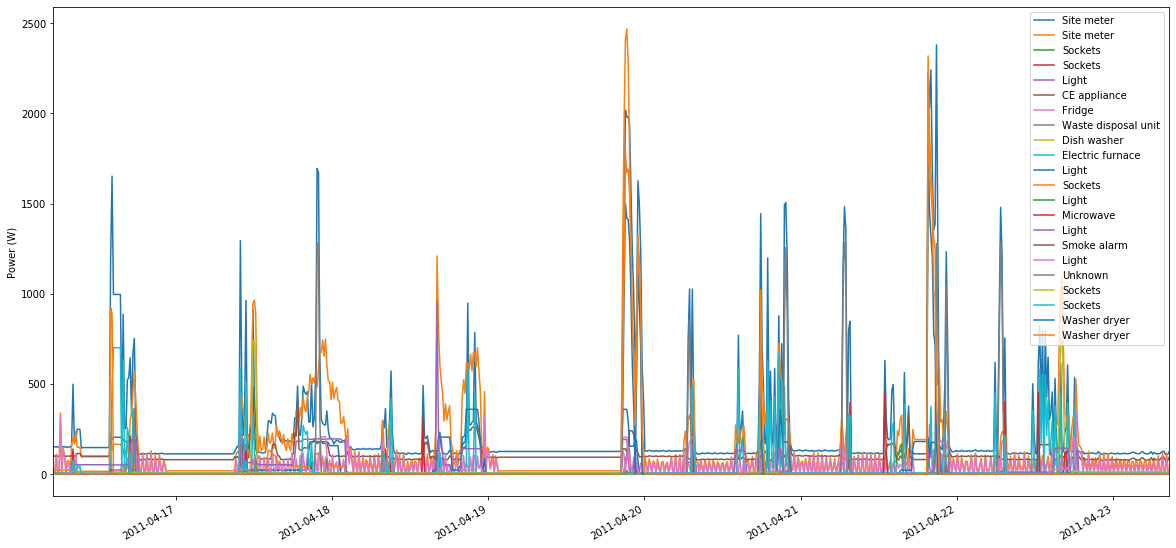

In [8]:
# Teste da classe
janelas = Janelas(
    base=redd,
    id_residencia=3,
    inicio_intervalo='2011-04-16 05:11:30',
    fim_intervalo='2011-04-23 08:43:26',
    debug = False
)


# Plots
fig = plt.figure(figsize=(20, 10))
print("Consumo geral dos medidores/aparelhos no período:")
for m in range(len(janelas.residencia.elec.meters)):
    janelas.residencia.elec.meters[m].plot();


In [9]:

# Extrair series divididas em janelas para cada medidor
# a cada 90 segundos, em uma taxa de 3s
dados_cargas = janelas.preparar(taxa_amostral=3, intervalo_medicao=90)

# Disposicao das janelas preparadas
dados_cargas

Loading data for meter ElecMeterID(instance=2, building=3, dataset='REDD')     
Done loading data all meters for this chunk.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.


[{'carga': 'site_meter',
  'instancia': 1,
  'janelas': array([[144.82    , 146.66667 , 146.01    , ..., 162.76666 , 160.01666 ,
          153.06667 ],
         [152.77666 , 152.92667 , 153.16333 , ..., 152.35666 , 152.29001 ,
          152.03667 ],
         [152.01    , 152.95334 , 153.31    , ..., 152.32666 , 152.03    ,
          152.45999 ],
         ...,
         [107.815   , 107.939995, 107.86    , ..., 108.13    , 108.130005,
          108.19    ],
         [108.11    , 108.22    , 108.096664, ..., 122.235   , 122.27334 ,
          122.47667 ],
         [122.39667 , 122.57333 , 121.11    , ..., 123.916664, 123.66    ,
          135.86333 ]], dtype=float32),
  'rotulos': {'total': array([4411.6836, 4590.323 , 4582.923 , ..., 3234.1533, 3507.4153,
          3672.055 ], dtype=float32),
   'media': array([147.05612, 153.01077, 152.7641 , ..., 107.80511, 116.91384,
          122.40183], dtype=float32),
   'estado': array([1, 1, 1, ..., 1, 1, 1])}},
 {'carga': 'site_meter',
  'instanc

In [10]:
# Listando as cargas que possuem janelas preparadas
janelas.lista_cargas(dados_cargas)

[(1, 'site_meter'),
 (2, 'site_meter'),
 (3, 'sockets'),
 (4, 'sockets'),
 (5, 'light'),
 (6, 'ce_appliance'),
 (7, 'fridge'),
 (8, 'waste_disposal_unit'),
 (9, 'dish_washer'),
 (10, 'electric_furnace'),
 (11, 'light'),
 (12, 'sockets'),
 (13, 'washer_dryer'),
 (14, 'washer_dryer'),
 (15, 'light'),
 (16, 'microwave'),
 (17, 'light'),
 (18, 'smoke_alarm'),
 (19, 'light'),
 (20, 'unknown')]

In [11]:
# Filtrando dados para conjunto de cargas
# NOTA: Os lares norte-americanos têm suprimentos de energia em fase dividida. 
#   Cada divisão é de 120 volts em relação ao neutro. As duas divisões 
#   totalizam 240 volts, por isso os dois 'site_meter'. 
#
#   Além disso, aparelhos que demandam energia (secadora, por exemplo) podem se 
#   conectar a ambas as divisões; na REDD se mede separadamente as duas divisões 
#   para esses tais aparelhos, contemplando no NILMTK dois medidores por 
#   dispositivo de 240 volts.

# Apenas duas fases da corrente eletrica da residencia
dados_medidores = janelas.filtrar_cargas(
    dados_cargas,
    filtros=[
        (1, 'site_meter'),
        (2, 'site_meter'),    
    ]
)
print("Dados das janelas de ambos medidores da residência:")
print("---")
pprint(dados_medidores)

print("\n\n")

# Apenas dados de aparelhos da residencia
dados_aparelhos = janelas.filtrar_cargas(
    dados_cargas,
    filtros=[
        (3, 'sockets'),
        (4, 'sockets'),
        (5, 'light'),
        (6, 'ce_appliance'),
        (7, 'fridge'),
        (8, 'waste_disposal_unit'),
        (9, 'dish_washer'),
        (10, 'electric_furnace'),
        (11, 'light'),
        (12, 'sockets'),
        (13, 'washer_dryer'),
        (14, 'washer_dryer'),
        (15, 'light'),
        (16, 'microwave'),
        (17, 'light'),
        (18, 'smoke_alarm'),
        (19, 'light'),
        (20, 'unknown')
    ]
)
print("Dados das janelas dos aparelhos da residência:")
print("---")
pprint(dados_aparelhos)


Dados das janelas de ambos medidores da residência:
---
[{'carga': 'site_meter',
  'instancia': 1,
  'janelas': array([[144.82    , 146.66667 , 146.01    , ..., 162.76666 , 160.01666 ,
        153.06667 ],
       [152.77666 , 152.92667 , 153.16333 , ..., 152.35666 , 152.29001 ,
        152.03667 ],
       [152.01    , 152.95334 , 153.31    , ..., 152.32666 , 152.03    ,
        152.45999 ],
       ...,
       [107.815   , 107.939995, 107.86    , ..., 108.13    , 108.130005,
        108.19    ],
       [108.11    , 108.22    , 108.096664, ..., 122.235   , 122.27334 ,
        122.47667 ],
       [122.39667 , 122.57333 , 121.11    , ..., 123.916664, 123.66    ,
        135.86333 ]], dtype=float32),
  'rotulos': {'estado': array([1, 1, 1, ..., 1, 1, 1]),
              'media': array([147.05612, 153.01077, 152.7641 , ..., 107.80511, 116.91384,
       122.40183], dtype=float32),
              'total': array([4411.6836, 4590.323 , 4582.923 , ..., 3234.1533, 3507.4153,
       3672.055 ], dtype

  'janelas': array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 0., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32),
  'rotulos': {'estado': array([1, 1, 1, ..., 1, 1, 1]),
              'media': array([1.        , 1.        , 1.        , ..., 0.96666664, 0.96666664,
       1.        ], dtype=float32),
              'total': array([30., 30., 30., ..., 29., 29., 30.], dtype=float32)}},
 {'carga': 'unknown',
  'instancia': 20,
  'janelas': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
  'rotulos': {'estado': array([0, 0, 0, ..., 0, 0, 0]),
              'media': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
              't

### Arquivo `graficorecorrencia.py`

In [12]:
from pyts.image import RecurrencePlot
from sklearn.preprocessing import MinMaxScaler



# ... (EM DESENVOLVIMENTO) ...




## Submódulo *`modelos`*

In [13]:
# ... (EM DESENVOLVIMENTO) ...

## Submódulo *`avaliacao`*

### Arquivo *`metricas.py`*

In [55]:
def recall_macro(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def precisao_macro(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def f1(y_true, y_pred):
    precision = precisao_macro(y_true, y_pred)
    recall = recall_macro(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))


def avaliar_threshold(pos_probs, threshold):
    """Verificar se a probabilidade é igual ou maior que um limiar para classe positiva"""
    return (pos_probs >= threshold).astype('int')

### Arquivo *`graficos.py`*

In [74]:
from matplotlib import pyplot as plt

plt.style.use('ggplot')
from tqdm import tqdm_notebook
from collections import Counter
import seaborn as sns
from sklearn.metrics import *
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_validate
from scipy import interpolate
import numpy as np
import pandas as pd

# from .metricas import *

def avaliar_threshold(pos_probs, threshold):
    """Verificar se a probabilidade é igual ou maior que um limiar para classe positiva"""
    return (pos_probs >= threshold).astype('int')

def plotar_previsto_esperado(test, predicted):
    # import matplotlib.pyplot as plt
    plt.plot(predicted.flatten(), label='pred')
    plt.plot(test.flatten(), label='Y')
    plt.show();
    return

def plotar_matriz_confusao(y_teste, y_pred, labels):
    
    matriz = confusion_matrix(y_teste, y_pred)
    
    seaborn.set(color_codes=True)
    plt.figure(1, figsize=(9, 6))

    plt.title("Matriz de Confusão")

    seaborn.set(font_scale=1.3)
    ax = seaborn.heatmap(matriz, annot=True, cmap='Reds', fmt='g')

    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

    ax.set(ylabel="Teste", xlabel="Previsto")
    
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    
    plt.show()

def plotar_curva_roc(modelo, X_teste, y_teste):
            
    probas = modelo.predict_proba(X_teste)
    tx_fp, tx_vp, threshold = roc_curve(y_teste, probas)
    roc_auc = auc(tx_fp, tx_vp)
    
    fig = plt.figure(figsize=(8, 8))
    plt.plot([0, 1], [0, 1], linestyle='--')#, label='Modelo Descalibrado')
    plt.plot(tx_fp, tx_vp, marker='.', label='AUC = %0.2f' % roc_auc)

    plt.xlabel('Taxa Falso Positivo (Especificidade)')
    plt.ylabel('Taxa Verdad. Positivo (Sensibilidade)')
    plt.legend()
    plt.title('Curva ROC do Classificador')

    plt.show()


def plotar_curva_pr(precisao, recall, thresholds, y_teste, best_thres_ix=None):
    fig = plt.figure(figsize=(8, 8))
    no_skill = len(y_teste[y_teste == 1]) / len(y_teste)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='Modelo Descalibrado')
    plt.plot(recall, precisao, marker='.', label='Resultados Classificador')
    if best_thres_ix is not None:
        plt.scatter(
            recall[best_thres_ix], precisao[best_thres_ix],
            marker='o', color='black',
            label='Melhor Threshold'
        )
    plt.xlabel('Recall')
    plt.ylabel('Precisão')
    plt.legend()
    plt.title('Curva PR (Precisão x Recall)')
    # show the plot
    plt.show()

### Arquivo *`analises.py`*

In [99]:
from sklearn.metrics import *
import numpy as np
import pandas as pd
from tensorflow.keras import backend as K
from IPython.display import display

# from metricas import *
# from graficos import *

def relatorio_classificacao(y_test, y_pred, labels=None):
    final_performance = []

    for i in range(y_test.shape[1]):
        test = y_test[:, i]
        predicted = y_pred[:, i]
        # acc, prec, rec, f1, f1m, hl, supp = metrics(y_test[:, i], y_pred[:, i])
        acc = accuracy_score(test, predicted)
        prec = precision_score(test, predicted)
        rec = recall_score(test, predicted)
        f1 = f1_score(test, predicted)
        f1m = f1_score(test, predicted, average='macro')
        hl = hamming_loss(test, predicted)
        auc_ = roc_auc_score(test, predicted)
        y_i = y_test[:, i]
        supp_0 = y_i[y_i == 0].shape[0]
        supp_1 = y_i[y_i == 1].shape[0]

        final_performance.append([
            labels[i] if labels is not None else i,
            round(acc * 100, 2),
            round(prec * 100, 2),
            round(rec * 100, 2),
            round(f1 * 100, 2),
            round(f1m * 100, 2),
            round(hl, 2),
            round(auc_, 2),
            supp_0,
            supp_1
        ])

    print("* Desempenho do Modelo Multi-rótulo por Aparelho:")
    df_metrics = pd.DataFrame(
        data=final_performance,
        columns=["Aparelho", "Acurácia", "Precisão", "Recall", "F1-score", "F1-macro", "Hamming Loss", "AUC",
                 "Suporte (y=0)", "Suporte (y=1)"]
    )
    display(df_metrics)

    print("")
    print("* Desempenho Médio Geral:")
    display(df_metrics.describe().round(2).loc[['mean', 'max', 'min']])

    print("")
    print("* Matriz de Confusão (Estados 0/1 - OFF/ON), por Aparelho:")

    cms = multilabel_confusion_matrix(y_test, y_pred)
    for i, a in enumerate(labels):
        print("")
        print(" - {}:".format(a))
        print(cms[i])
    # print(, labels= appliance_labels)


def relatorio_classificacao_aparelho(modelo, X_teste, y_teste, label=None):
    final_performance = []
    
    label = ''.join([label[0].upper(), label[-(len(label)-1):].lower()])
    y_pred = modelo.predict(X_teste).round()
    
    test = y_teste
    predicted = y_pred
    # acc, prec, rec, f1, f1m, hl, supp = metrics(y_teste[:, i], y_pred[:, i])
    acc = accuracy_score(test, predicted)
    prec = precision_score(test, predicted)
    rec = recall_score(test, predicted)
    f1 = f1_score(test, predicted)
    f1m = f1_score(test, predicted, average='macro')
    hl = hamming_loss(test, predicted)
    auc_ = roc_auc_score(test, predicted) if len(np.unique(test)) > 1 else 0
    y_i = y_teste
    supp_0 = y_i[y_i == 0].shape[0]
    supp_1 = y_i[y_i == 1].shape[0]
    
    final_performance = [[
#         label,
        round(acc * 100, 2),
        round(prec * 100, 2),
        round(rec * 100, 2),
        round(f1 * 100, 2),
        round(f1m * 100, 2),
        round(hl, 2),
        round(auc_, 2),
        supp_0,
        supp_1
    ]]

    print("* Desempenho do Classificador `{}`:".format(label))
    df_metrics = pd.DataFrame(
        data=final_performance,
        index = [label],
        columns=["Acurácia", "Precisão", "Recall", "F1-score", "F1-macro", "Hamming Loss", "AUC",
                 "Suporte (y=0)", "Suporte (y=1)"]
    )
    display(df_metrics.transpose())

    print("")
    print("* Matriz de Confusão (Estados 0/1 - OFF/ON):")
    plotar_matriz_confusao(y_teste, y_pred, labels=np.unique(y_teste))        

    print("")
    print("* Análise Curva ROC:")
    plotar_curva_roc(modelo, X_teste, y_teste)

    print("")
    print("* Análise de Convergência do Modelo:")

    # accuracy
    historico = modelo.history
    fig = plt.figure(figsize=(15,5))
    plt.plot(historico.history['accuracy'])
    plt.plot(historico.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoca')
    plt.legend(['treino', 'teste'], loc='upper left')
    plt.show()

    # loss
    fig = plt.figure(figsize=(15,5))
    plt.plot(historico.history['loss'])
    plt.plot(historico.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoca')
    plt.legend(['treino', 'teste'], loc='upper left')
    plt.show()
        
def avaliar_modelo_binario_cv(modelo, X, y, threshold=None, folds=10, exibir_relatorio=False, tamanho_teste=0.3, seed=42):
    """
    Função de avaliação para labels binários, com suporte a ROC.
    """
    # Métricas de avaliação
    accuracies = []
    precisions = []
    recalls = []
    f1s = []
    f1_micros = []
    roc_aucs = []
    # Métricas classe minoritaria
    accuracies_min = []
    precisions_min = []
    recalls_min = []
    f1s_min = []
    f1_micros_min = []
    # roc_aucs_min = []

    # Variaveis auxiliares para Plot ROC-Folds
    # VSF FDP
    tprs = []
    fprs = []
    aucs = []
    base_fpr = np.linspace(0, 1, 101)

    # Selecionando a classe minoritaria
    classe_minoritaria = Counter(y).most_common()[-1][0]

    # Splits estratificados
    fig = plt.figure(figsize=(8, 8))
    print("Validando usando K-folds (K={})...".format(folds))
    skf = StratifiedKFold(n_splits=folds, random_state=seed, shuffle=True)
    for i, (treino_ix, teste_ix) in tqdm_notebook(enumerate(skf.split(X, y)), total=folds):

        # Preparar dados
        # Teste
        if type(X) == pd.core.frame.DataFrame:
            X_treino = X.loc[treino_ix, :]
        else:
            if len(X.shape) > 1:
                X_treino = X[treino_ix, :]
            else:
                X_treino = X[treino_ix]
        y_treino = pd.factorize(y[treino_ix])[0]
        # Teste
        if type(X) == pd.core.frame.DataFrame:
            X_teste = X.loc[teste_ix, :]
        else:
            if len(X.shape) > 1:
                X_teste = X[teste_ix, :]
            else:
                X_teste = X[teste_ix]
        y_teste = pd.factorize(y[teste_ix])[0]

        # Ajustando modelo
        pipeline = modelo
        pipeline.fit(X_treino, y_treino)

        # Inferindo no conjunto de teste
        y_pred = pipeline.predict(X_teste)
        y_proba = pipeline.predict_proba(X_teste)[:, 1]

        # Verificar uso de threshold, p/ transformar em rotulo discreto
        if threshold is not None:
            y_pred = avaliar_threshold(y_proba, threshold)

        # Avaliando previsoes
        accuracies.append(accuracy_score(y_teste, y_pred))
        precisions.append(precision_score(y_teste, y_pred, average='macro'))
        recalls.append(recall_score(y_teste, y_pred, average='macro'))
        f1s.append(f1_score(y_teste, y_pred, average='macro'))
        f1_micros.append(f1_score(y_teste, y_pred, average='micro'))
        roc_aucs.append(roc_auc_score(y_teste, y_proba, average='macro'))

        # Registros da classe minoritaria (indices)
        i_min = np.where(y_teste == classe_minoritaria)
        # Avaliando previsoes
        accuracies_min.append(accuracy_score(y_teste[i_min], y_pred[i_min]))
        precisions_min.append(precision_score(y_teste[i_min], y_pred[i_min], average='macro'))
        recalls_min.append(recall_score(y_teste[i_min], y_pred[i_min], average='macro'))
        f1_micros_min.append(f1_score(y_teste[i_min], y_pred[i_min], average='micro'))
        f1s_min.append(f1_score(y_teste[i_min], y_pred[i_min], average='macro'))
        # roc_aucs_min.append(roc_auc_score(y_teste[i_min], y_pred[i_min], average='macro'))

        # Plotando curva ROC FOLD #i
        fpr, tpr, thresholds = roc_curve(y_teste, y_proba)
        fold_auc = auc(fpr, tpr)
        plt.plot(
            fpr, tpr, 'b', alpha=0.15,
            label=r'ROC fold {} (AUC = {:.2f})'.format(i, fold_auc)
        )
        tpr = interpolate(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs.append(tpr)
        aucs.append(fold_auc)

    # Plotar Media ROCs K-folds
    tprs = np.array(tprs)
    mean_tprs = tprs.mean(axis=0)
    std = tprs.std(axis=0)
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    tprs_upper = np.minimum(mean_tprs + std, 1)
    tprs_lower = mean_tprs - std
    plt.plot(base_fpr, mean_tprs, 'b',
             label=r'ROC Média (AUC = {:.2f} $\pm$ {:.2f})'.format(mean_auc, std_auc))
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.33)
    plt.plot([0, 1], [0, 1], 'r--', label='Modelo Descalibrado')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.title('Curvas ROC | K-Folds')
    plt.ylabel('Taxa de Verdadeiro Positivo (Sensibilidade)')
    plt.xlabel('Taxa de Falso Positivo (Especificidade)')
    plt.legend()
    plt.axes().set_aspect('equal', 'datalim')
    plt.show()

    # Relatorio de classificacao para um fold aleatorio
    if exibir_relatorio:

        print("Score médio do pipeline ({}-Folds):".format(folds))
        print("- - - - - - - - - - -")
        print("Acurácia:", np.mean(accuracies).round(2))
        print("Precisão:", np.mean(precisions).round(2))
        print("Recall:", np.mean(recalls).round(2))
        print("F1-macro:", np.mean(f1s).round(2))
        print("F1-micro:", np.mean(f1_micros).round(2))
        print("AUC ROC:", np.mean(roc_aucs).round(2))
        print("- - - - - -")
        print("   Métricas da Classe minoritária ({}):".format(classe_minoritaria))
        print()
        print("   -> accuracy:", np.mean(accuracies_min).round(2))
        print("   -> precision_macro:", np.mean(precisions_min).round(2))
        print("   -> recall_macro:", np.mean(recalls_min).round(2))
        print("   -> f1_macro:", np.mean(f1s_min).round(2))
        print("   -> f1_micro:", np.mean(f1_micros_min).round(2))
        # print("   -> roc_auc:", np.mean(roc_aucs_min).round(2))

        # Split estratificado
        print()
        print("=" * 100)
        print()
        print("Validando no conjunto de Treino/Teste (teste = {})...".format(tamanho_teste))
        X_treino, X_teste, y_treino, y_teste = train_test_split(
            X, y,
            test_size=tamanho_teste,
            stratify=y,
            random_state=seed
        )

        # Isntanciando pipeline
        pipeline = modelo
        pipeline.fit(X_treino, y_treino)

        # Inferindo no conjunto de teste
        y_pred = pipeline.predict(X_teste)
        y_proba = pipeline.predict_proba(X_teste)[:, 1]

        # Verificar uso de threshold, p/ transformar em rotulo discreto
        if threshold is not None:
            y_pred = avaliar_threshold(y_proba, threshold)

        # Calcular e exibir curva ROC / thresholds
        tfp, tvp, thresholds = roc_curve(y_teste, y_proba)
        plotar_curva_roc(tfp, tvp, thresholds)

        # Calcular e execiver curva PR / thresholds
        ps, rs, thresholds = precision_recall_curve(y_teste, y_proba)
        plotar_curva_pr(ps, rs, thresholds, y_teste)

        # Métricas do modelo para o conjunto de teste
        print(classification_report(y_teste, y_pred))

    return (precisions, recalls, f1s, roc_aucs)


def avaliar_modelo_multiclasse(modelo, X, y, threshold=None, folds=10, exibir_relatorio=False, tamanho_teste=0.3,
                               seed=42):
    """
    Função de avaliação para conjuntos de dados multiclasse, sem suporte a ROC.
    """
    # Métricas de avaliação
    accuracies = []
    precisions = []
    recalls = []
    f1s = []
    f1_micros = []

    # Métricas classe minoritaria
    accuracies_min = []
    precisions_min = []
    recalls_min = []
    f1s_min = []
    f1_micros_min = []

    # Selecionando a classe minoritaria
    classe_minoritaria = Counter(y).most_common()[-1][0]

    # Splits estratificados
    print("Validando usando K-folds (K={})...".format(folds))
    skf = StratifiedKFold(n_splits=folds, random_state=seed, shuffle=True)
    for i, (treino_ix, teste_ix) in tqdm_notebook(enumerate(skf.split(X, y)), total=folds):

        # Preparar dados
        # Teste
        if type(X) == pd.core.frame.DataFrame:
            X_treino = X.loc[treino_ix, :]
        else:
            if len(X.shape) > 1:
                X_treino = X[treino_ix, :]
            else:
                X_treino = X[treino_ix]
        y_treino = pd.factorize(y[treino_ix])[0]
        # Teste
        if type(X) == pd.core.frame.DataFrame:
            X_teste = X.loc[teste_ix, :]
        else:
            if len(X.shape) > 1:
                X_teste = X[teste_ix, :]
            else:
                X_teste = X[teste_ix]
        y_teste = pd.factorize(y[teste_ix])[0]

        # Ajustando modelo
        pipeline = modelo
        pipeline.fit(X_treino, y_treino)

        # Inferindo no conjunto de teste
        y_pred = pipeline.predict(X_teste)
        y_proba = pipeline.predict_proba(X_teste)[:, 1]

        # Verificar uso de threshold, p/ transformar em rotulo discreto
        if threshold is not None:
            y_pred = avaliar_threshold(y_proba, threshold)

        # Avaliando previsoes
        accuracies.append(accuracy_score(y_teste, y_pred))
        precisions.append(precision_score(y_teste, y_pred, average='macro'))
        recalls.append(recall_score(y_teste, y_pred, average='macro'))
        f1s.append(f1_score(y_teste, y_pred, average='macro'))
        f1_micros.append(f1_score(y_teste, y_pred, average='micro'))

        # Registros da classe minoritaria (indices)
        i_min = np.where(y_teste == classe_minoritaria)
        # Avaliando previsoes
        accuracies_min.append(accuracy_score(y_teste[i_min], y_pred[i_min]))
        precisions_min.append(precision_score(y_teste[i_min], y_pred[i_min], average='macro'))
        recalls_min.append(recall_score(y_teste[i_min], y_pred[i_min], average='macro'))
        f1_micros_min.append(f1_score(y_teste[i_min], y_pred[i_min], average='micro'))
        f1s_min.append(f1_score(y_teste[i_min], y_pred[i_min], average='macro'))

    # Relatorio de classificacao para um fold aleatorio
    if exibir_relatorio:

        print("Score médio do pipeline ({}-Folds):".format(folds))
        print("- - - - - - - - - - -")
        print("Acurácia:", np.mean(accuracies).round(2))
        print("Precisão:", np.mean(precisions).round(2))
        print("Recall:", np.mean(recalls).round(2))
        print("F1-macro:", np.mean(f1s).round(2))
        print("F1-micro:", np.mean(f1_micros).round(2))

        print("- - - - - -")
        print("   Métricas da Classe minoritária ({}):".format(classe_minoritaria))
        print()
        print("   -> accuracy:", np.mean(accuracies_min).round(2))
        print("   -> precision_macro:", np.mean(precisions_min).round(2))
        print("   -> recall_macro:", np.mean(recalls_min).round(2))
        print("   -> f1_macro:", np.mean(f1s_min).round(2))
        print("   -> f1_micro:", np.mean(f1_micros_min).round(2))
        # print("   -> roc_auc:", np.mean(roc_aucs_min).round(2))

        # Split estratificado
        print()
        print("=" * 100)
        print()
        print("Validando no conjunto de Treino/Teste (teste = {})...".format(tamanho_teste))
        print()
        X_treino, X_teste, y_treino, y_teste = train_test_split(
            X, y,
            test_size=tamanho_teste,
            stratify=y,
            random_state=seed
        )

        # Isntanciando pipeline
        pipeline = modelo
        pipeline.fit(X_treino, y_treino)

        # Inferindo no conjunto de teste
        y_pred = pipeline.predict(X_teste)
        y_proba = pipeline.predict_proba(X_teste)[:, 1]

        # Verificar uso de threshold, p/ transformar em rotulo discreto
        if threshold is not None:
            y_pred = avaliar_threshold(y_proba, threshold)

        # Métricas do modelo para o conjunto de teste
        print(classification_report(y_teste, y_pred))

    return (precisions, recalls, f1s)


def avaliar_modelo_multirotulo(modelo, X, y, rotulos=None, threshold=None, folds=10, exibir_relatorio=False,
                               tamanho_teste=0.3, seed=42):
    """
    Função de avaliação para labels binários, com suporte a ROC.
    """
    # Métricas de avaliação
    scores = cross_validate(
        modelo,
        X, y,
        scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'f1_micro'],
        cv=folds,
    )
    accuracies = scores["test_accuracy"]
    precisions = scores["test_precision_macro"]
    recalls = scores["test_recall_macro"]
    f1s = scores["test_f1_macro"]
    f1_micros = scores["test_f1_micro"]

    # Relatorio de classificacao para um fold aleatorio
    if exibir_relatorio:

        print("Score médio do pipeline ({}-Folds):".format(folds))
        print("- - - - - - - - - - -")
        print("Acurácia:", np.mean(accuracies).round(2))
        print("Precisão:", np.mean(precisions).round(2))
        print("Recall:", np.mean(recalls).round(2))
        print("F1-macro:", np.mean(f1s).round(2))
        print("F1-micro:", np.mean(f1_micros).round(2))

        # Split
        print()
        print("=" * 58)
        print()
        print("Validando no conjunto de Treino/Teste (teste = {})...".format(tamanho_teste))
        print()
        print("-> Relatório de classificação:")
        print()
        X_treino, X_teste, y_treino, y_teste = train_test_split(
            X, y,
            test_size=tamanho_teste,
            stratify=y,
            random_state=seed
        )

        # Instanciando pipeline
        pipeline = modelo
        pipeline.fit(X_treino, y_treino)

        # Inferindo no conjunto de teste
        y_pred = pipeline.predict(X_teste)
        y_proba = pipeline.predict_proba(X_teste)[:, 1]

        # Verificar uso de threshold, p/ transformar em rotulo discreto
        if threshold is not None:
            y_pred = avaliar_threshold(y_proba, threshold)

        # Métricas do modelo para o conjunto de teste
        print(classification_report(y_teste, y_pred, labels=rotulos))

        # Erros/acertos do modelo para o conjunto de teste
        print("-" * 58)
        print()
        print("-> Matriz de confusão multilabel:")
        print()
        print(multilabel_confusion_matrix(y_teste, y_pred, labels=rotulos))

    return (precisions, recalls, f1s)



# Teste do Pipeline utilizando PyNILM

In [100]:
from collections import Counter
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.applications.vgg16 import preprocess_input

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, Conv1D, MaxPooling2D, MaxPool1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 4GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*4)]
        )
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)
        
def convnet(
    input_shape_ = (30, 30,3), 
    output_dim=6, 
    loss_function = 'binary_crossentropy', 
    metrics=['accuracy'],
    output_activation = 'softmax'
):
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu", input_shape=input_shape_))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))    
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(output_dim, activation=output_activation))

    model.compile(optimizer='adam', loss=[loss_function], metrics=metrics)
    
    return model

1 Physical GPUs, 1 Logical GPUs


Dados dos medidores (X):
   - Media: 0.31549752
   - Desvio: 0.33858845


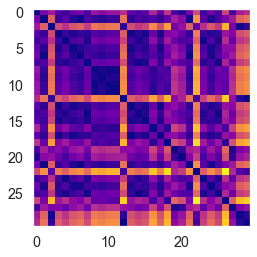

In [101]:
from sklearn.preprocessing import StandardScaler

rp = RecurrencePlot()

# Janelas do medidores agregados
X_janela = dados_medidores[0]["janelas"] + dados_medidores[1]["janelas"]

# Normalizando dados
X_janela = MinMaxScaler().fit_transform(X_janela.T).T

print("Dados dos medidores (X):")
print("   - Media:", np.mean(X_janela))
print("   - Desvio:", np.std(X_janela))

# Extraindo RPs
X_rp = rp.fit_transform(X_janela)
plt.imshow(X_rp[3], cmap="plasma");
plt.grid(False)

# Gerando imagens RGB 3 canais
X_rp = np.stack([X_rp, X_rp, X_rp], axis=-1)

In [102]:
# top_appliances = [
#     {"id": 6, "label": "CE appliance"},
#     {"id": 7, "label": "Fridge"},
#     {"id": 10, "label": "Electric furnace"},
#     {"id": 13, "label": "Washer dryer"},
#     {"id": 14, "label": "Washer dryer"},
#     {"id": 17, "label": "Light"} # *
# ]

In [ ]:
# Estados do aparelho 'fridge'
aparelho = janelas.filtrar_cargas(dados_aparelhos, filtros=[(7, 'fridge')])[0]
y = aparelho["rotulos"]["estado"]

print(f"Dados do aparelho `{aparelho['carga'].upper()}` (Y / rótulo:)")
print("   - ", Counter(y))
print()
      
# Split de treino / teste
X_treino, X_teste, y_treino, y_teste = train_test_split(
    X_rp, y,
    test_size=.1,
    stratify=y,
    random_state=42
)
      
# Treinando modelo
modelo = convnet(
    input_shape_= X_rp[0,:,:].shape,
    output_dim = 1,
    loss_function='binary_crossentropy',
    metrics=['accuracy'],
    output_activation='sigmoid'
)

historico = modelo.fit(
    X_treino, y_treino,
    validation_data=(X_teste, y_teste),
    epochs=100,
    batch_size=64,
    verbose=2
)

# Avaliando modelo
print("="*120)
print("")
relatorio_classificacao_aparelho(modelo, X_teste, y_teste, f'{aparelho["carga"]} - {aparelho["instancia"]}')

Avaliando modelos binários para TODOS os aparelhos, aguarde...


* Dados do aparelho `SOCKETS - 3` (Y / rótulo:)
   -  Counter({0: 4497, 1: 2364})

* Treinando o modelo classificador de estados...

* Desempenho do Classificador `Sockets - 3`:


,Sockets - 3
Acurácia,73.66
Precisão,64.04
Recall,53.64
F1-score,58.38
F1-macro,69.56
Hamming Loss,0.26
AUC,0.69
Suporte (y=0),1125.00
Suporte (y=1),591.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):


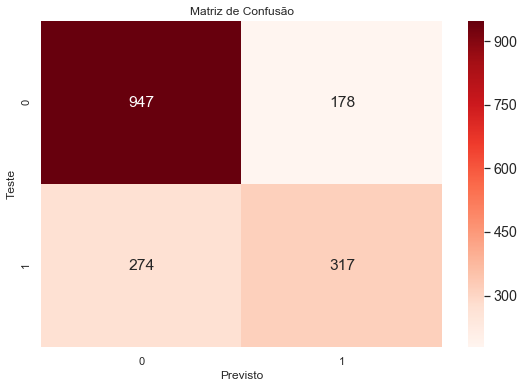


* Análise Curva ROC:


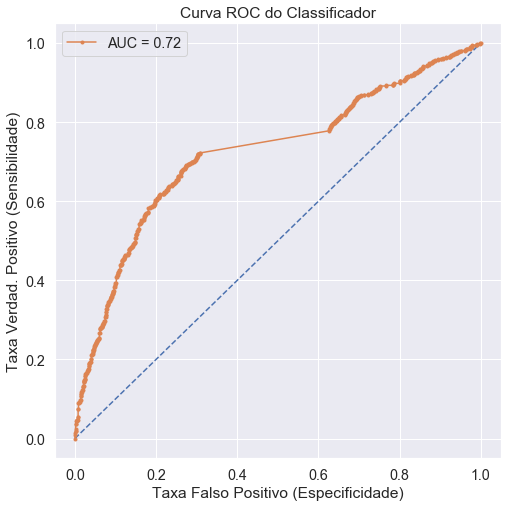


* Análise de Convergência do Modelo:


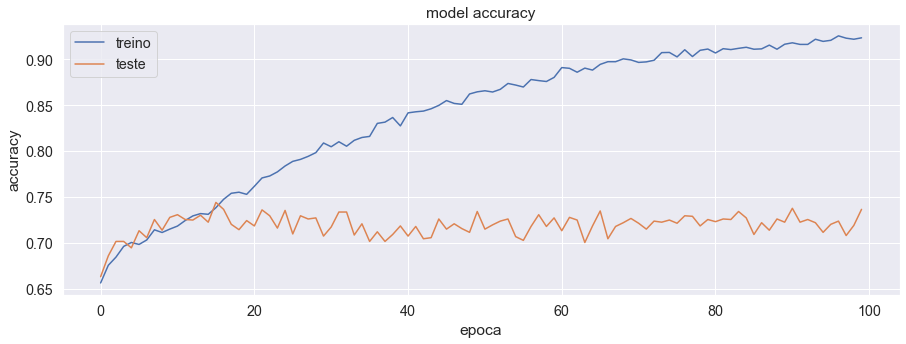

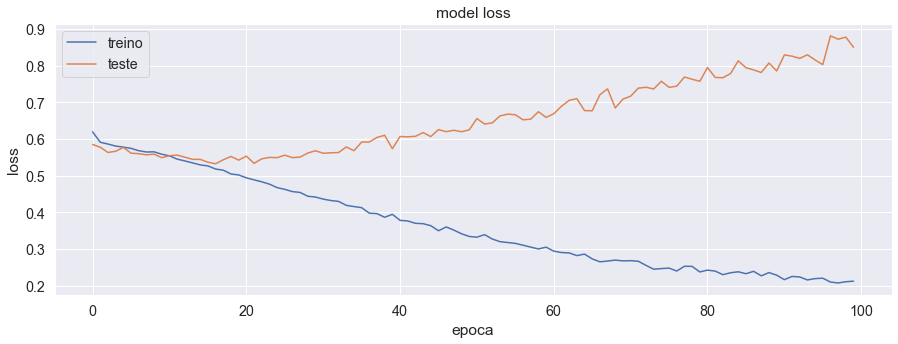



* Dados do aparelho `SOCKETS - 4` (Y / rótulo:)
   -  Counter({0: 5858, 1: 1003})

* Treinando o modelo classificador de estados...

* Desempenho do Classificador `Sockets - 4`:


,Sockets - 4
Acurácia,84.03
Precisão,42.18
Recall,24.70
F1-score,31.16
F1-macro,61.06
Hamming Loss,0.16
AUC,0.59
Suporte (y=0),1465.00
Suporte (y=1),251.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):


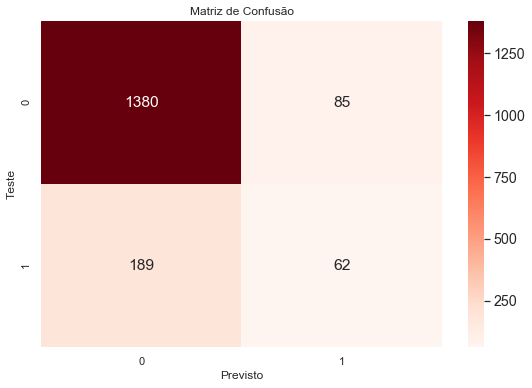


* Análise Curva ROC:


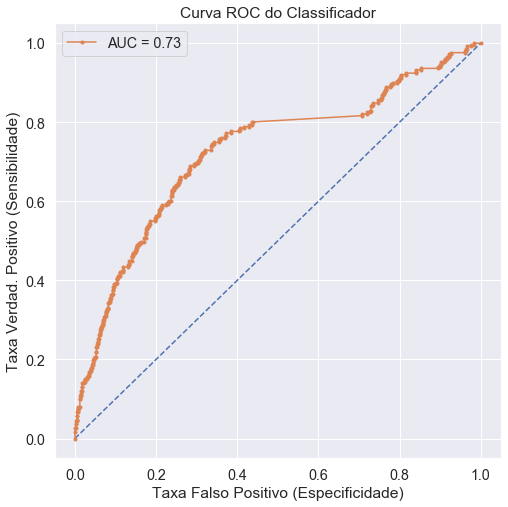


* Análise de Convergência do Modelo:


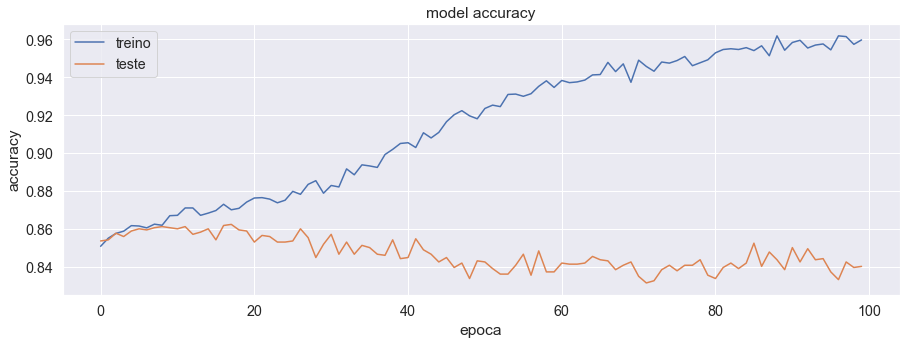

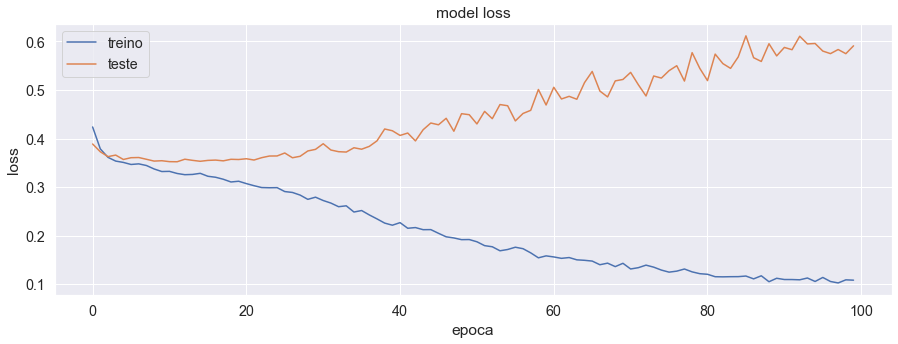



* Dados do aparelho `LIGHT - 5` (Y / rótulo:)
   -  Counter({0: 6092, 1: 769})

* Treinando o modelo classificador de estados...

* Desempenho do Classificador `Light - 5`:


,Light - 5
Acurácia,86.07
Precisão,30.58
Recall,19.27
F1-score,23.64
F1-macro,57.99
Hamming Loss,0.14
AUC,0.57
Suporte (y=0),1524.00
Suporte (y=1),192.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):


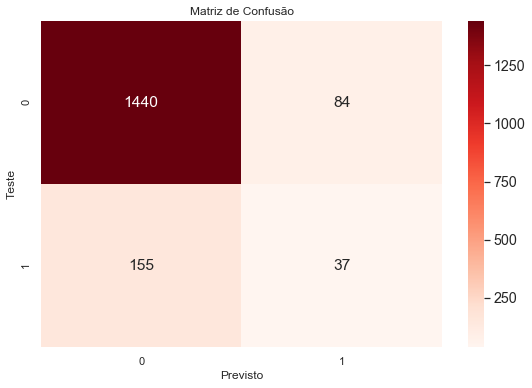


* Análise Curva ROC:


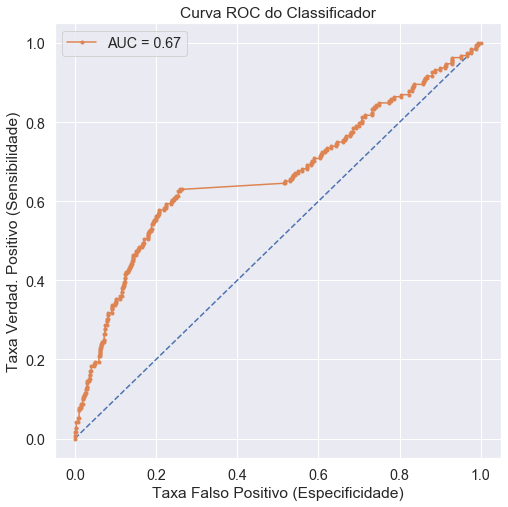


* Análise de Convergência do Modelo:


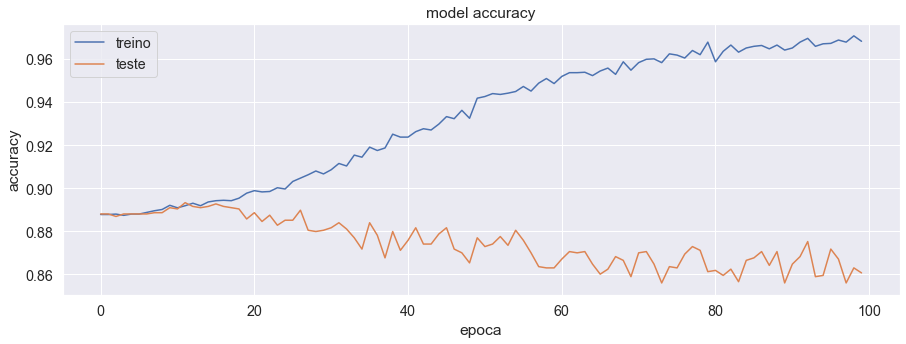

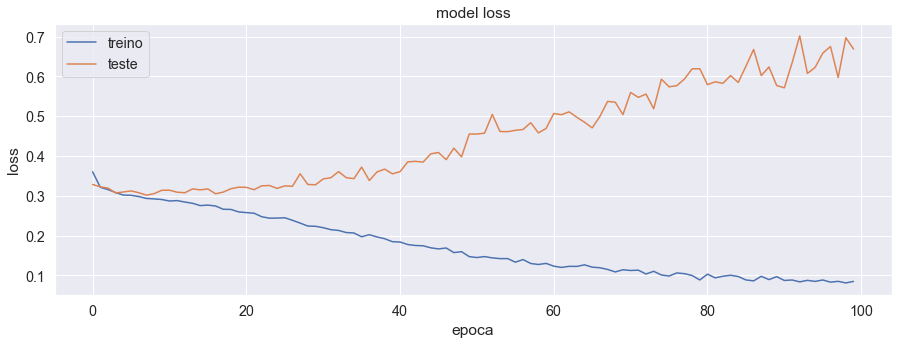



* Dados do aparelho `CE_APPLIANCE - 6` (Y / rótulo:)
   -  Counter({1: 6861})

* Treinando o modelo classificador de estados...

* Desempenho do Classificador `Ce_appliance - 6`:


,Ce_appliance - 6
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),0.0
Suporte (y=1),1716.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):


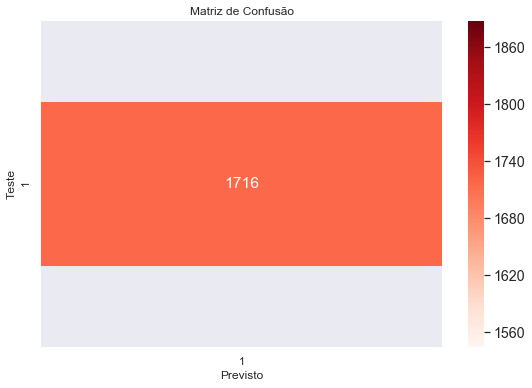


* Análise Curva ROC:


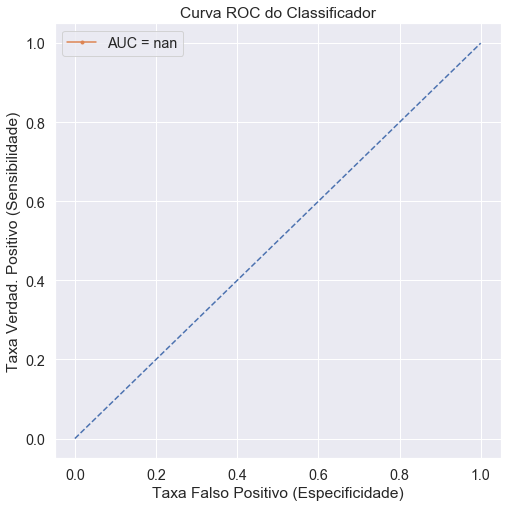


* Análise de Convergência do Modelo:


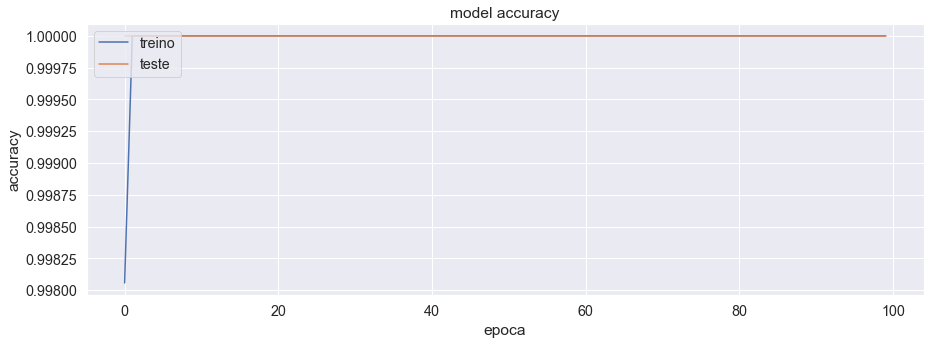

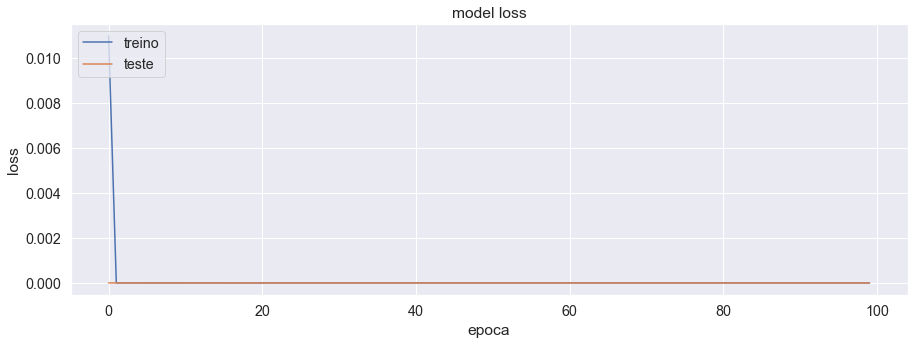



* Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({1: 5844, 0: 1017})

* Treinando o modelo classificador de estados...

* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,87.12
Precisão,97.40
Recall,87.21
F1-score,92.02
F1-macro,79.30
Hamming Loss,0.13
AUC,0.87
Suporte (y=0),254.00
Suporte (y=1),1462.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):


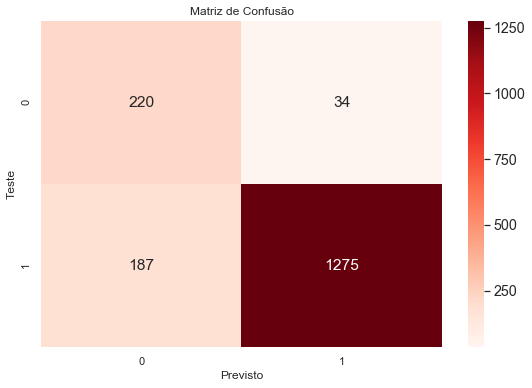


* Análise Curva ROC:


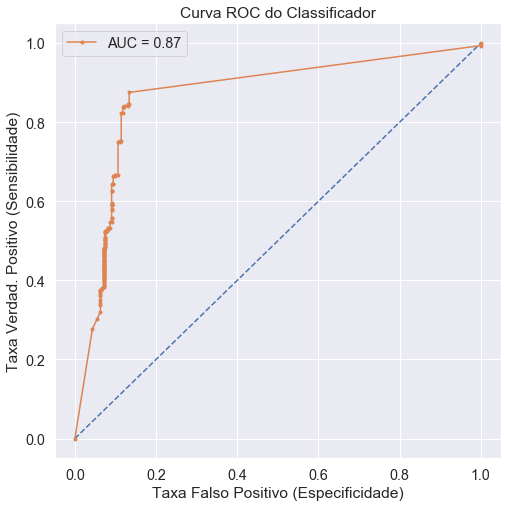


* Análise de Convergência do Modelo:


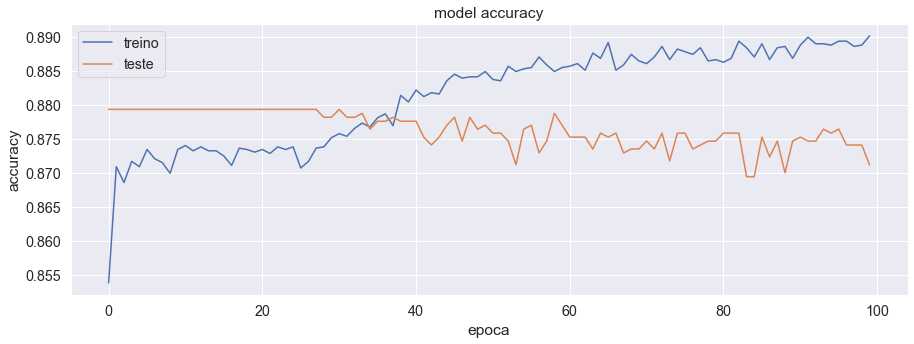

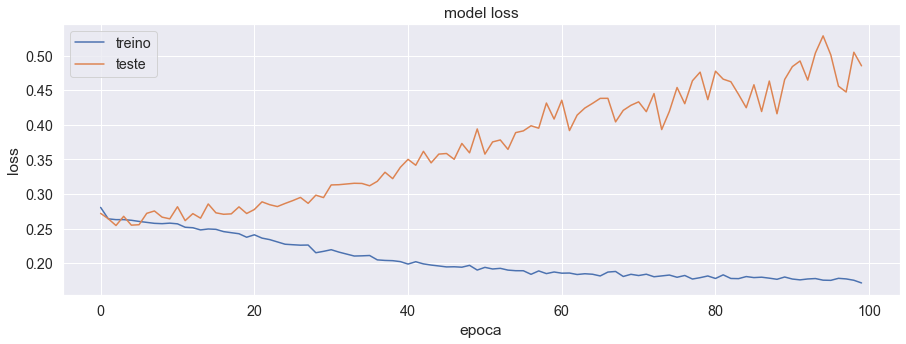



* Dados do aparelho `WASTE_DISPOSAL_UNIT - 8` (Y / rótulo:)
   -  Counter({0: 6138, 1: 723})

* Treinando o modelo classificador de estados...

* Desempenho do Classificador `Waste_disposal_unit - 8`:


,Waste_disposal_unit - 8
Acurácia,87.65
Precisão,36.04
Recall,22.10
F1-score,27.40
F1-macro,60.32
Hamming Loss,0.12
AUC,0.59
Suporte (y=0),1535.00
Suporte (y=1),181.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):


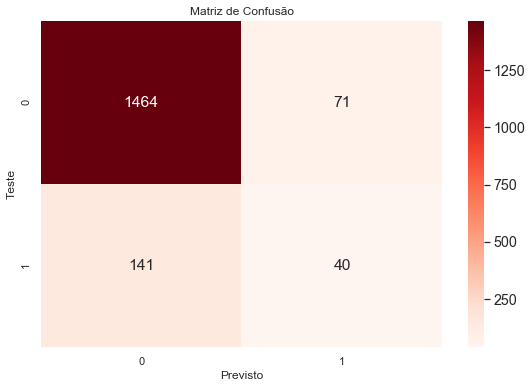


* Análise Curva ROC:


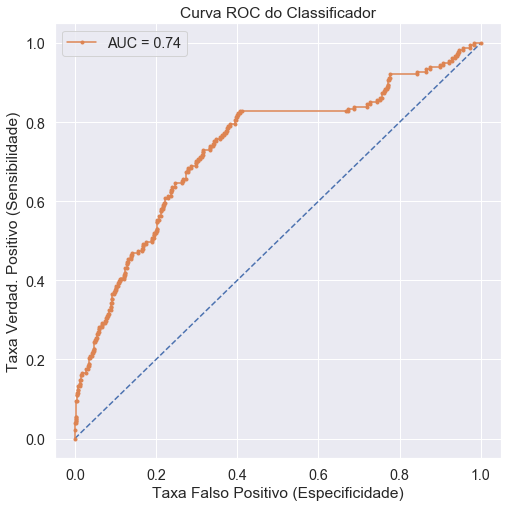


* Análise de Convergência do Modelo:


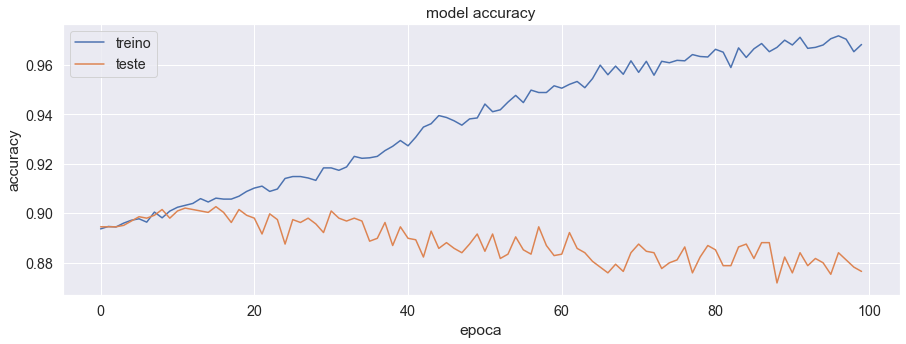

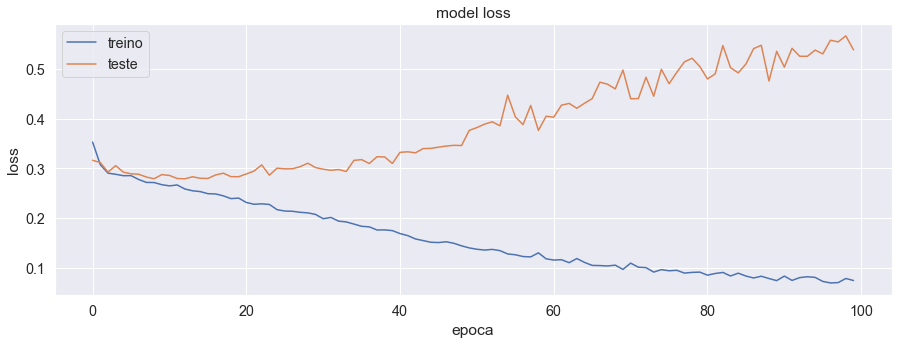



* Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({1: 6339, 0: 522})

* Treinando o modelo classificador de estados...

* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,91.08
Precisão,92.32
Recall,98.55
F1-score,95.33
F1-macro,48.31
Hamming Loss,0.09
AUC,0.50
Suporte (y=0),131.00
Suporte (y=1),1585.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):


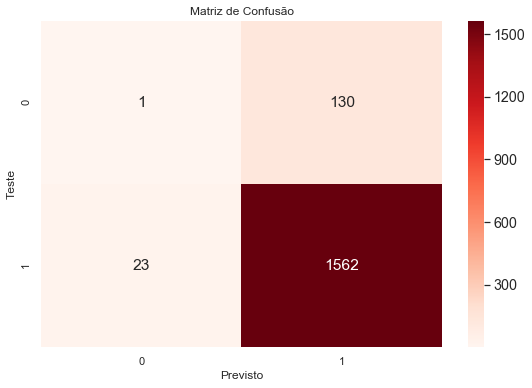


* Análise Curva ROC:


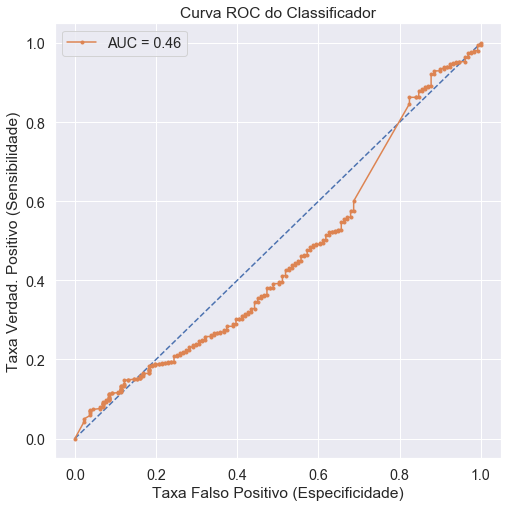


* Análise de Convergência do Modelo:


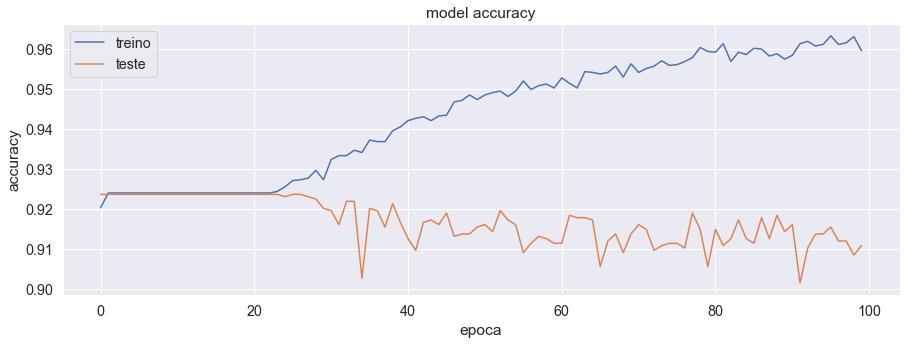

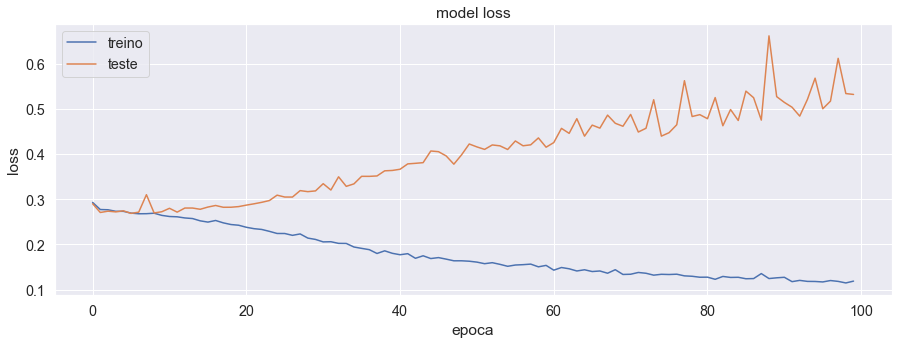



* Dados do aparelho `ELECTRIC_FURNACE - 10` (Y / rótulo:)
   -  Counter({1: 6833, 0: 28})

* Treinando o modelo classificador de estados...

* Desempenho do Classificador `Electric_furnace - 10`:


,Electric_furnace - 10
Acurácia,99.59
Precisão,99.59
Recall,100.00
F1-score,99.80
F1-macro,49.90
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),7.00
Suporte (y=1),1709.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):


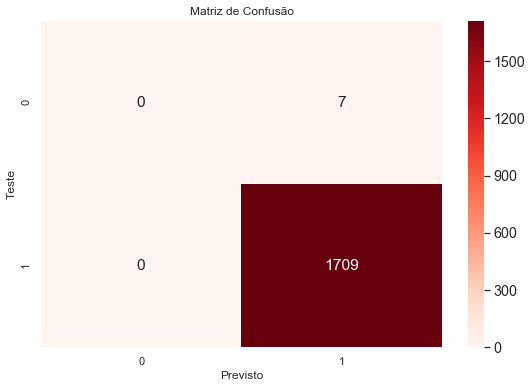


* Análise Curva ROC:


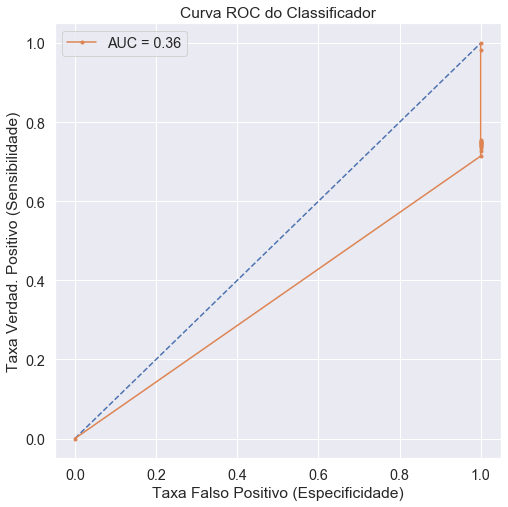


* Análise de Convergência do Modelo:


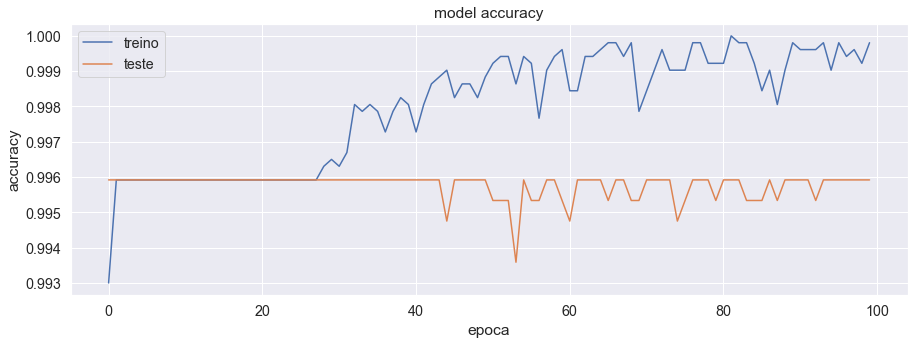

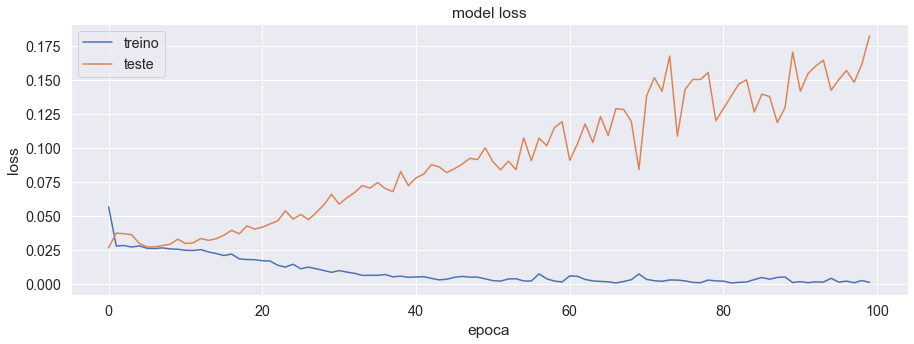



* Dados do aparelho `LIGHT - 11` (Y / rótulo:)
   -  Counter({0: 5056, 1: 1805})

* Treinando o modelo classificador de estados...

* Desempenho do Classificador `Light - 11`:


,Light - 11
Acurácia,72.03
Precisão,45.87
Recall,35.70
F1-score,40.15
F1-macro,60.95
Hamming Loss,0.28
AUC,0.60
Suporte (y=0),1265.00
Suporte (y=1),451.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):


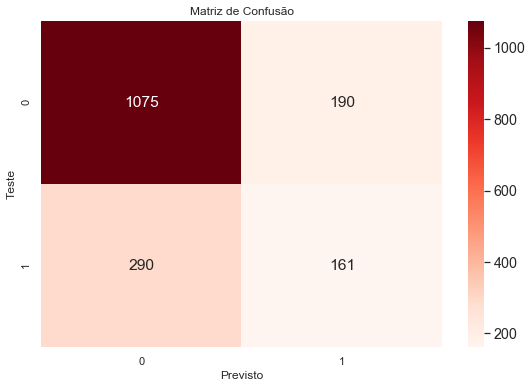


* Análise Curva ROC:


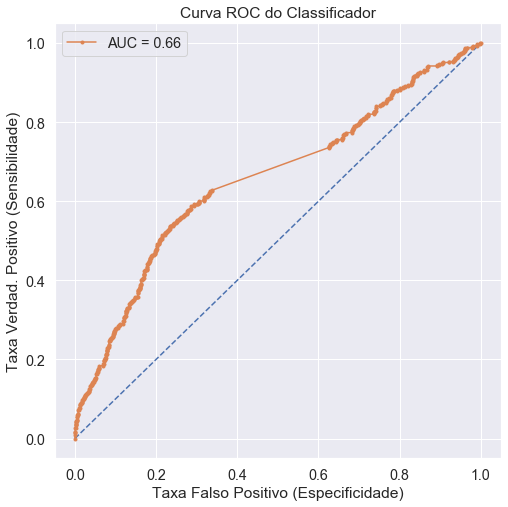


* Análise de Convergência do Modelo:


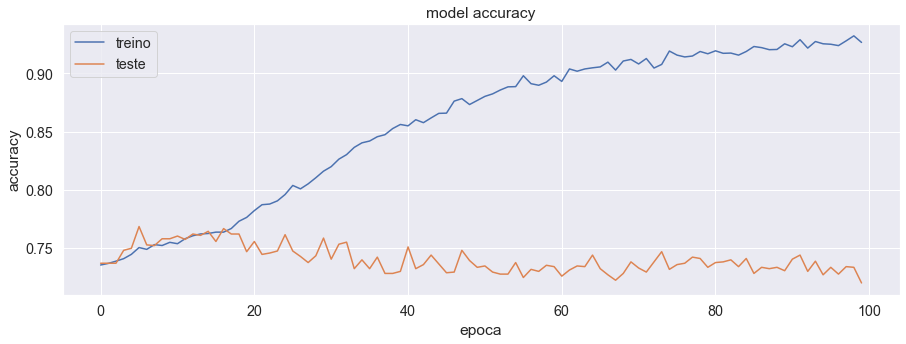

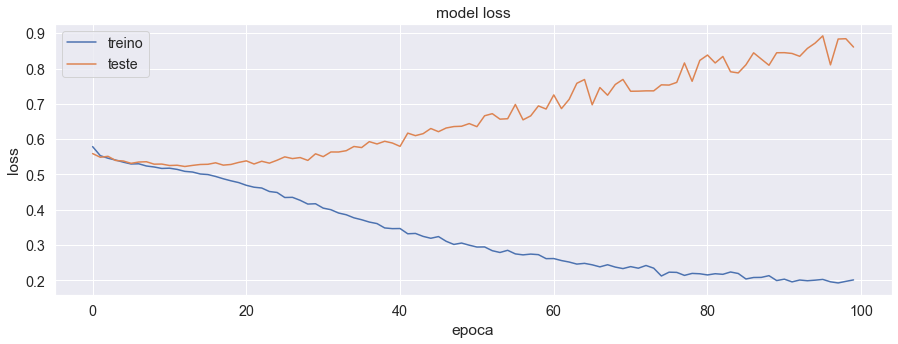



* Dados do aparelho `SOCKETS - 12` (Y / rótulo:)
   -  Counter({0: 4866, 1: 1995})

* Treinando o modelo classificador de estados...

* Desempenho do Classificador `Sockets - 12`:


,Sockets - 12
Acurácia,67.83
Precisão,42.54
Recall,30.26
F1-score,35.36
F1-macro,56.98
Hamming Loss,0.32
AUC,0.57
Suporte (y=0),1217.00
Suporte (y=1),499.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):


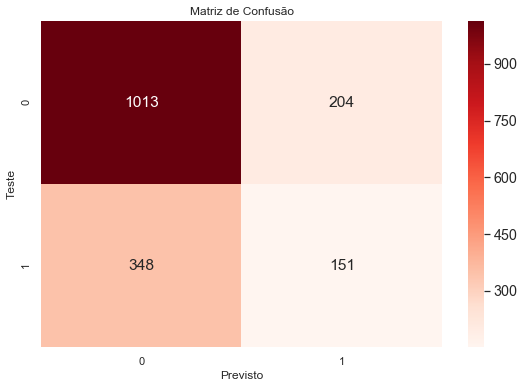


* Análise Curva ROC:


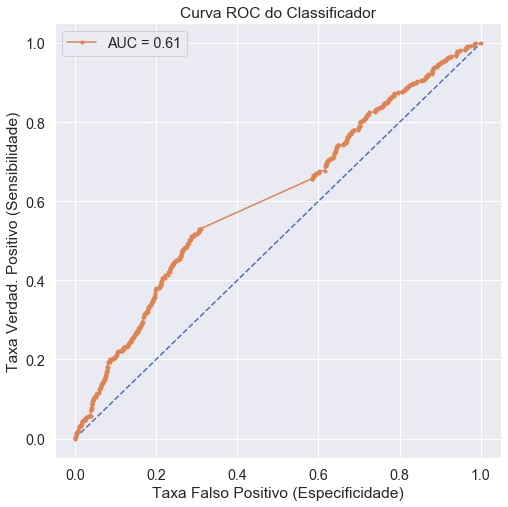


* Análise de Convergência do Modelo:


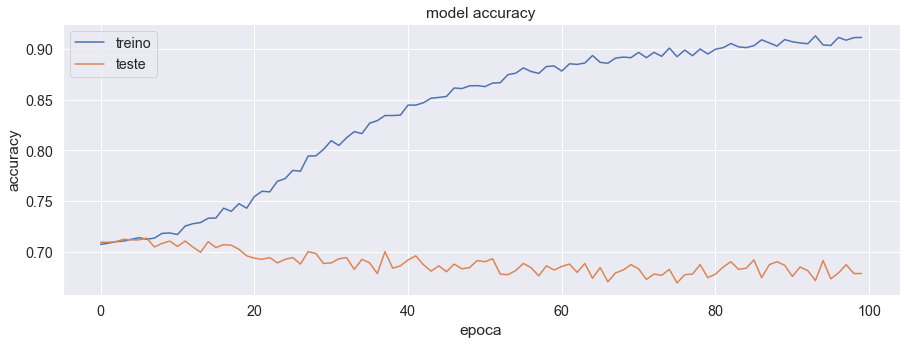

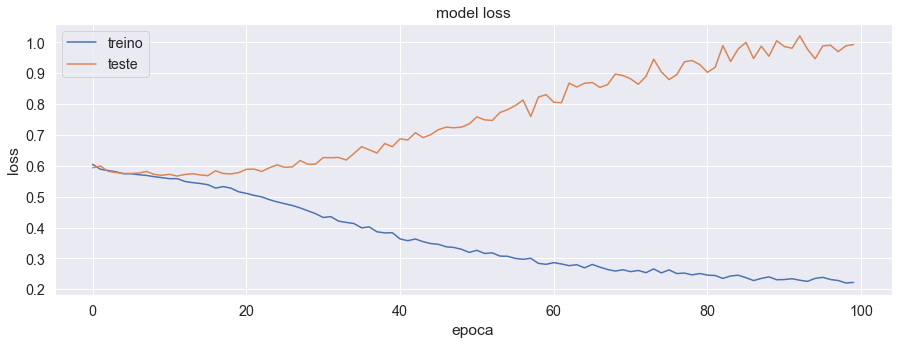



* Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 6613, 1: 248})

* Treinando o modelo classificador de estados...

* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,95.98
Precisão,40.00
Recall,22.58
F1-score,28.87
F1-macro,63.40
Hamming Loss,0.04
AUC,0.61
Suporte (y=0),1654.00
Suporte (y=1),62.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):


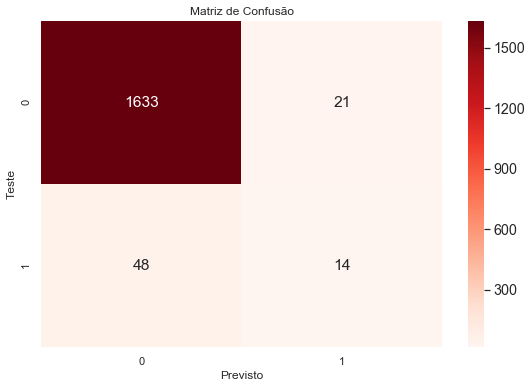


* Análise Curva ROC:


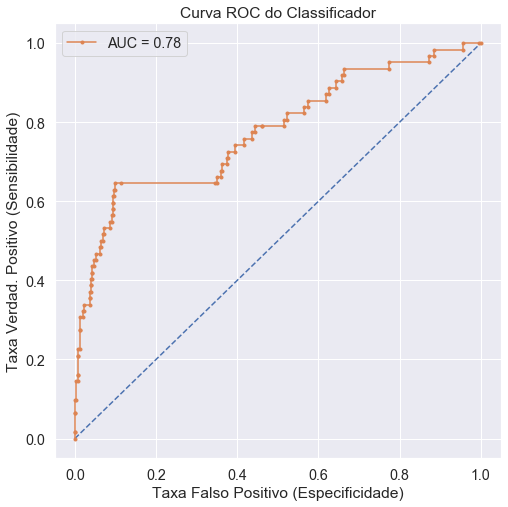


* Análise de Convergência do Modelo:


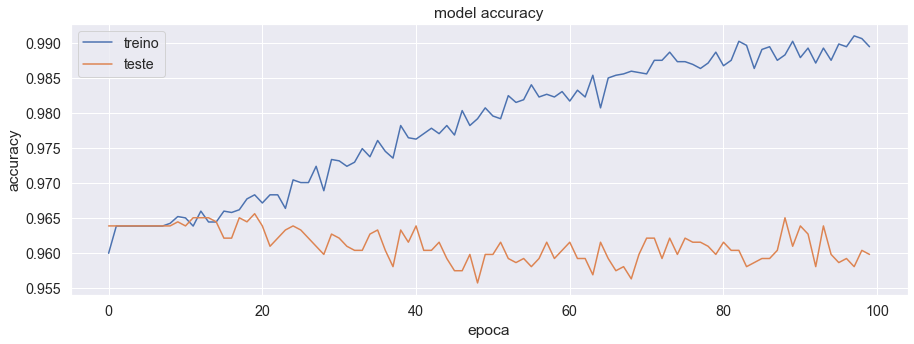

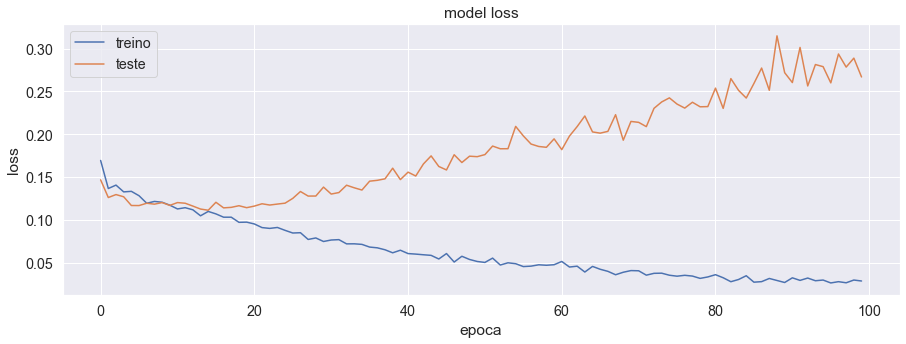



* Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 6540, 1: 321})

* Treinando o modelo classificador de estados...

* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,94.93
Precisão,44.44
Recall,35.00
F1-score,39.16
F1-macro,68.26
Hamming Loss,0.05
AUC,0.66
Suporte (y=0),1636.00
Suporte (y=1),80.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):


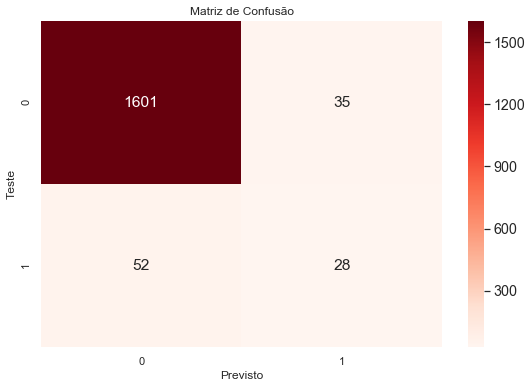


* Análise Curva ROC:


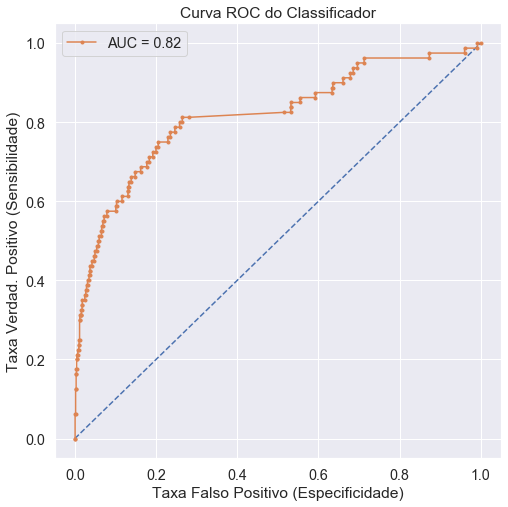


* Análise de Convergência do Modelo:


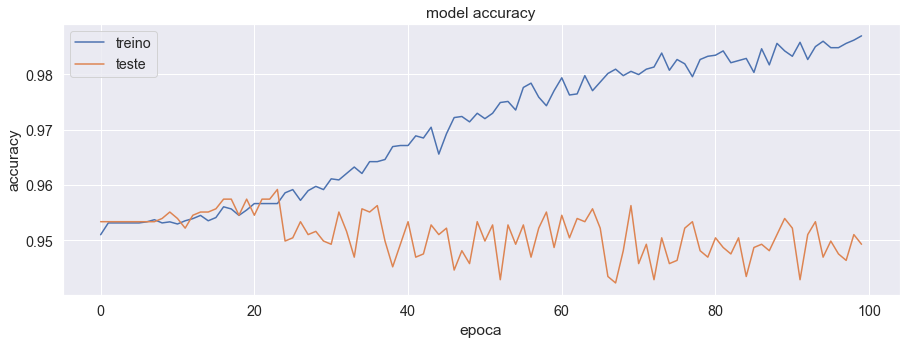

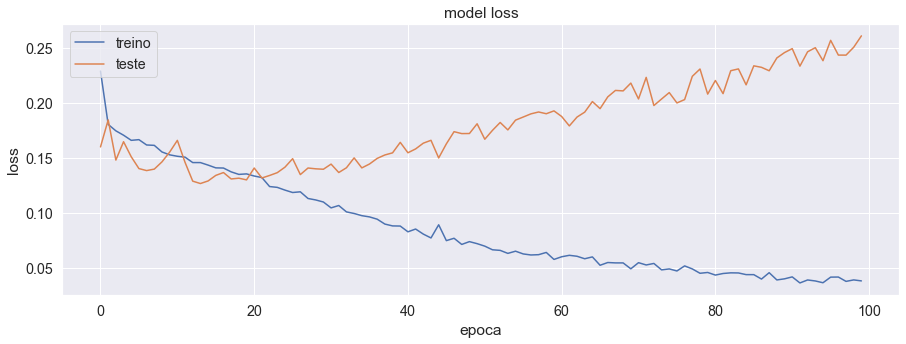



* Dados do aparelho `LIGHT - 15` (Y / rótulo:)
   -  Counter({0: 5515, 1: 1346})

* Treinando o modelo classificador de estados...

* Desempenho do Classificador `Light - 15`:


,Light - 15
Acurácia,80.71
Precisão,51.60
Recall,28.78
F1-score,36.95
F1-macro,62.78
Hamming Loss,0.19
AUC,0.61
Suporte (y=0),1379.00
Suporte (y=1),337.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):


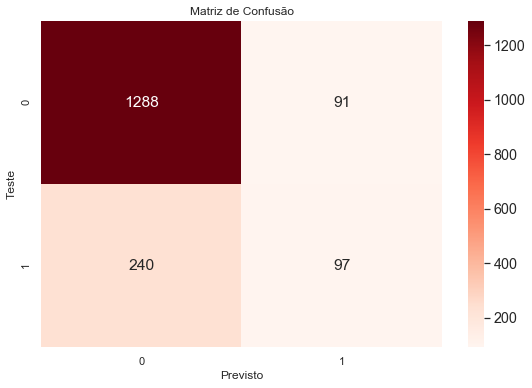


* Análise Curva ROC:


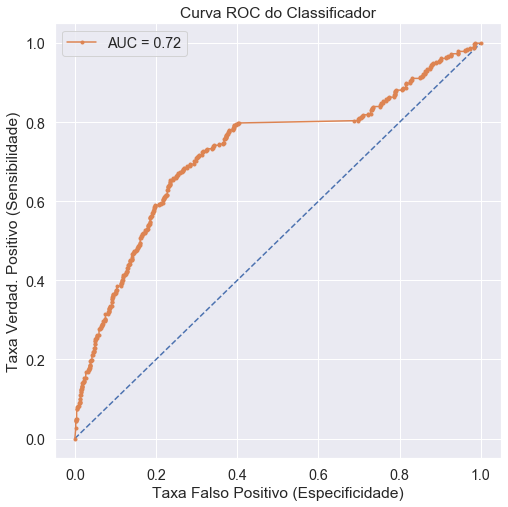


* Análise de Convergência do Modelo:


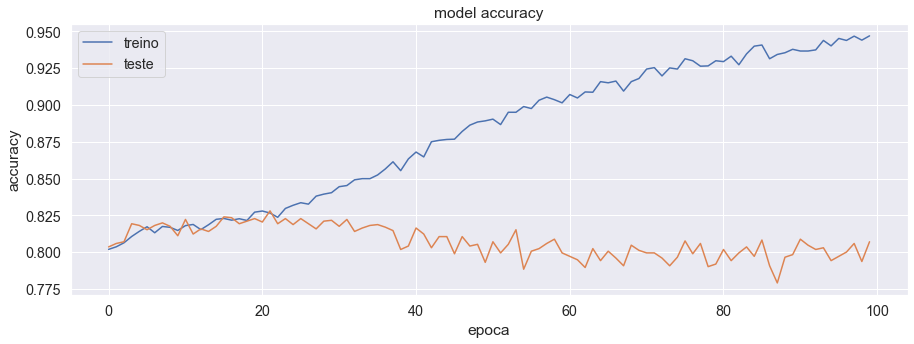

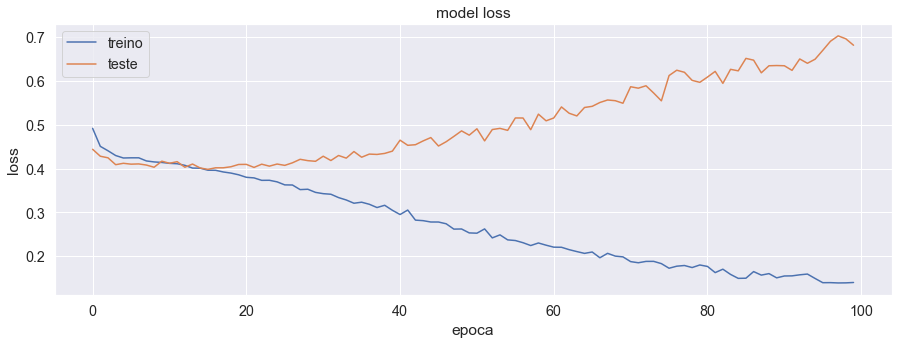



* Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({1: 6766, 0: 95})

* Treinando o modelo classificador de estados...

* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,98.37
Precisão,98.60
Recall,99.76
F1-score,99.18
F1-macro,49.59
Hamming Loss,0.02
AUC,0.50
Suporte (y=0),24.00
Suporte (y=1),1692.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):


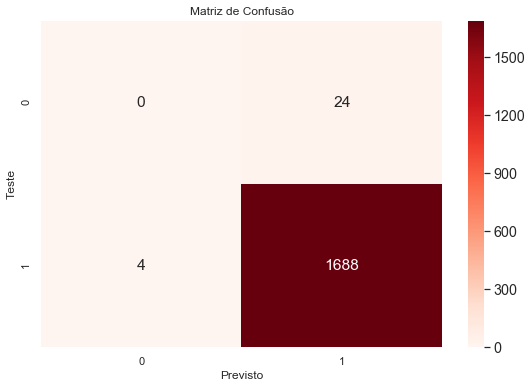


* Análise Curva ROC:


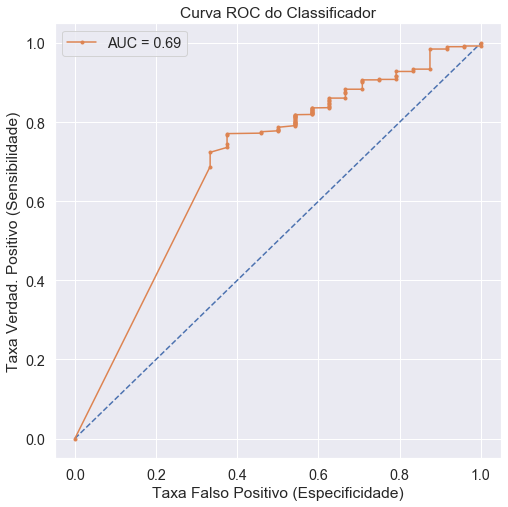


* Análise de Convergência do Modelo:


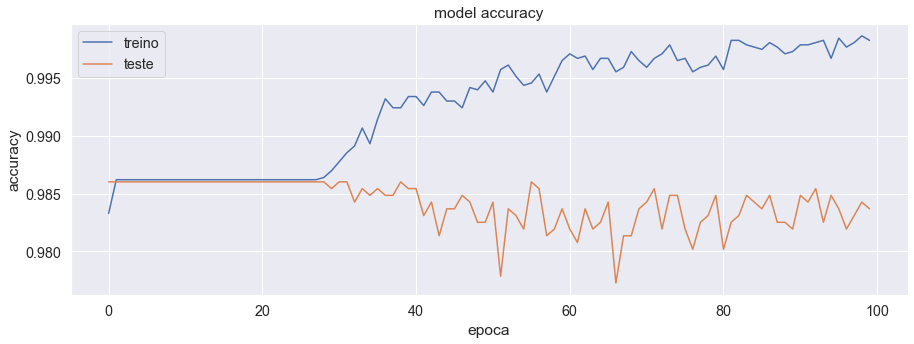

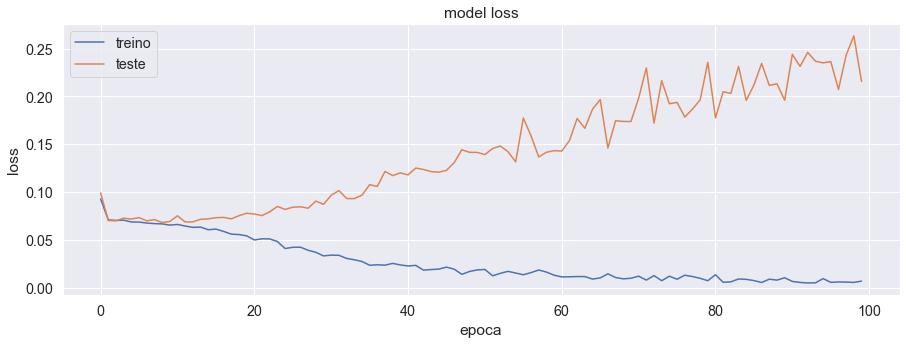



* Dados do aparelho `LIGHT - 17` (Y / rótulo:)
   -  Counter({0: 4428, 1: 2433})

* Treinando o modelo classificador de estados...

* Desempenho do Classificador `Light - 17`:


,Light - 17
Acurácia,68.30
Precisão,58.49
Recall,36.78
F1-score,45.16
F1-macro,61.43
Hamming Loss,0.32
AUC,0.61
Suporte (y=0),1107.00
Suporte (y=1),609.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):


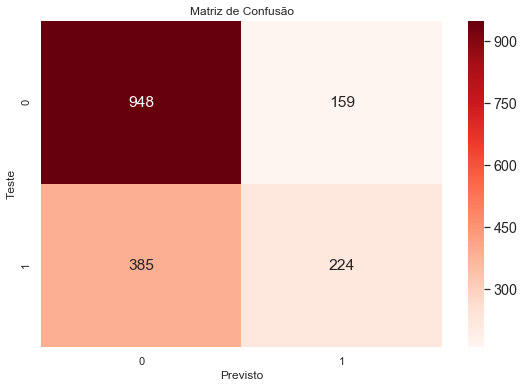


* Análise Curva ROC:


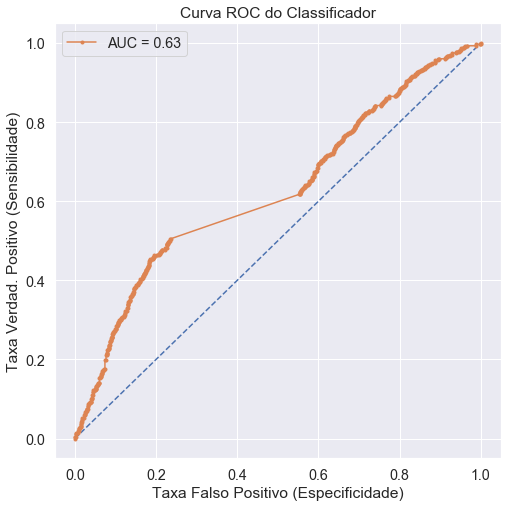


* Análise de Convergência do Modelo:


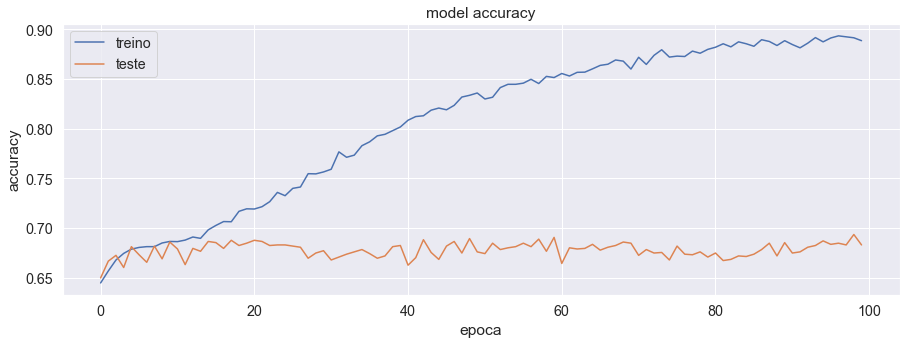

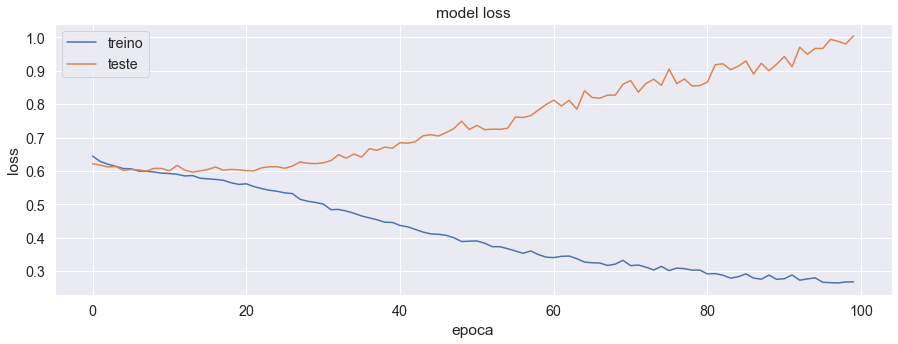



* Dados do aparelho `SMOKE_ALARM - 18` (Y / rótulo:)
   -  Counter({1: 6449, 0: 412})

* Treinando o modelo classificador de estados...

* Desempenho do Classificador `Smoke_alarm - 18`:


,Smoke_alarm - 18
Acurácia,92.48
Precisão,94.22
Recall,98.02
F1-score,96.08
F1-macro,52.30
Hamming Loss,0.08
AUC,0.52
Suporte (y=0),103.00
Suporte (y=1),1613.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):


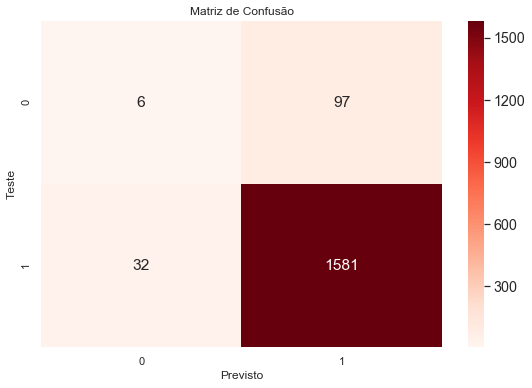


* Análise Curva ROC:


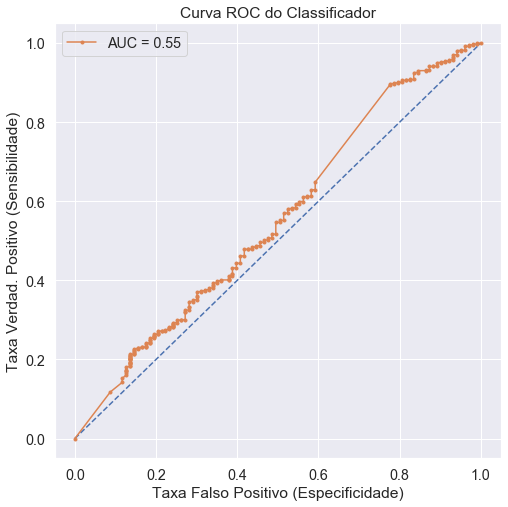


* Análise de Convergência do Modelo:


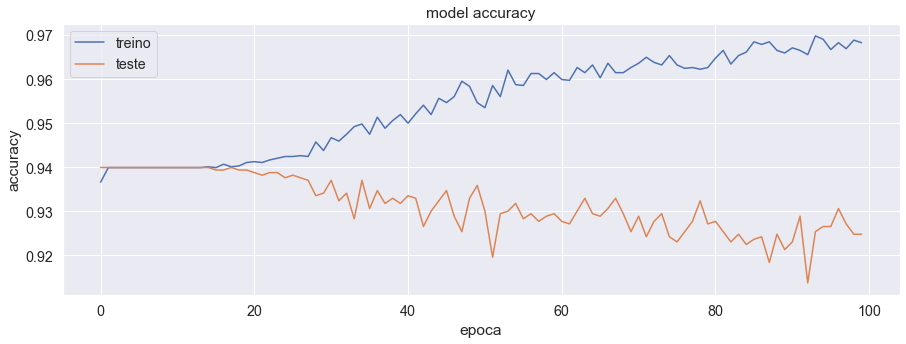

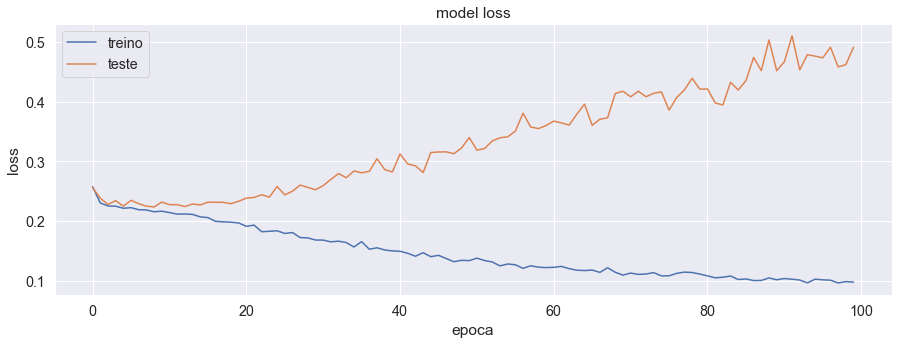



* Dados do aparelho `LIGHT - 19` (Y / rótulo:)
   -  Counter({1: 6828, 0: 33})

* Treinando o modelo classificador de estados...

* Desempenho do Classificador `Light - 19`:


,Light - 19
Acurácia,99.36
Precisão,99.53
Recall,99.82
F1-score,99.68
F1-macro,49.84
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),8.00
Suporte (y=1),1708.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):


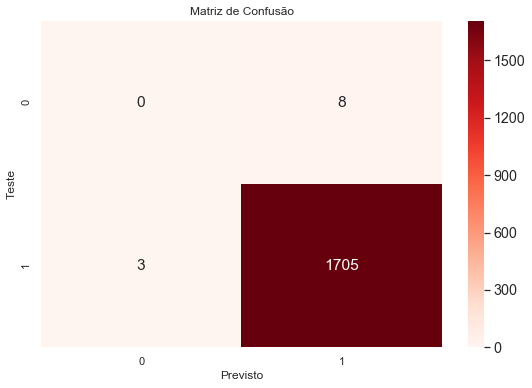


* Análise Curva ROC:


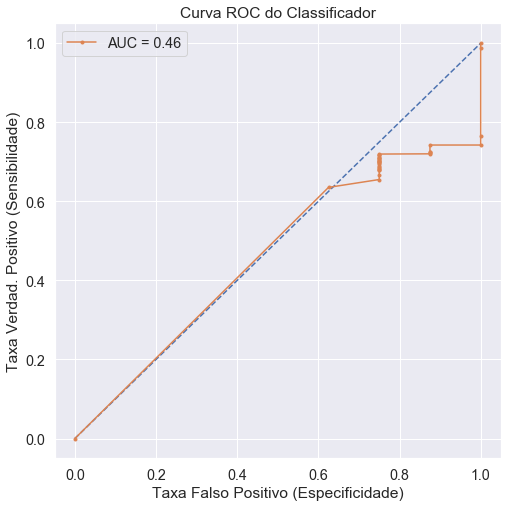


* Análise de Convergência do Modelo:


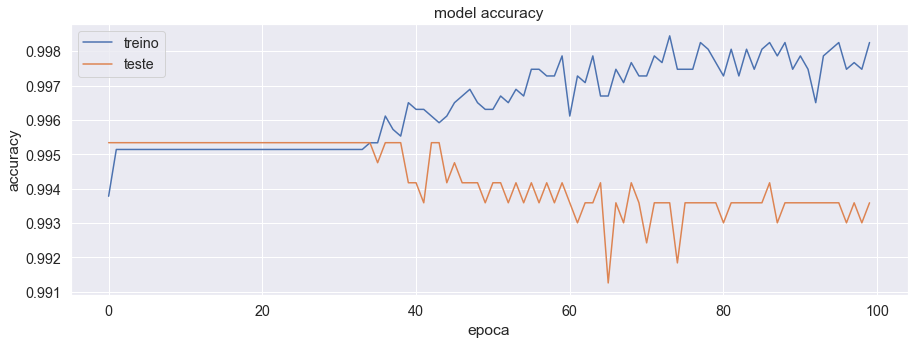

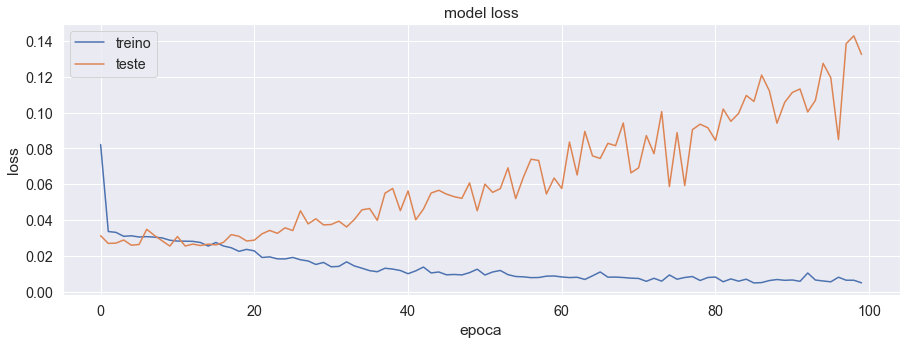



* Dados do aparelho `UNKNOWN - 20` (Y / rótulo:)
   -  Counter({0: 6187, 1: 674})

* Treinando o modelo classificador de estados...

* Desempenho do Classificador `Unknown - 20`:


,Unknown - 20
Acurácia,87.06
Precisão,18.82
Recall,9.47
F1-score,12.60
F1-macro,52.81
Hamming Loss,0.13
AUC,0.53
Suporte (y=0),1547.00
Suporte (y=1),169.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):


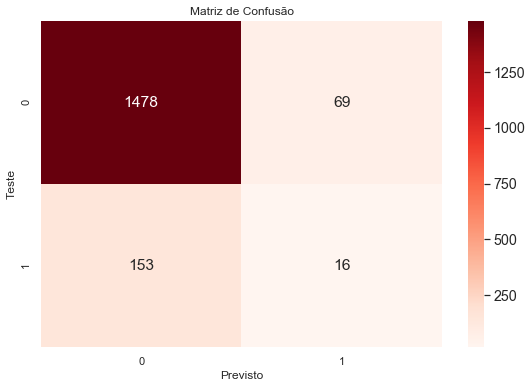


* Análise Curva ROC:


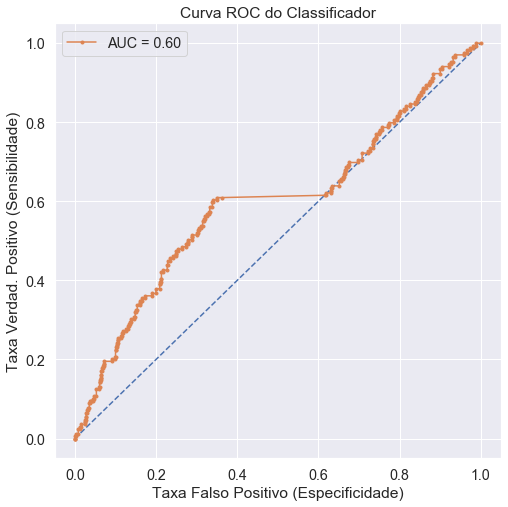


* Análise de Convergência do Modelo:


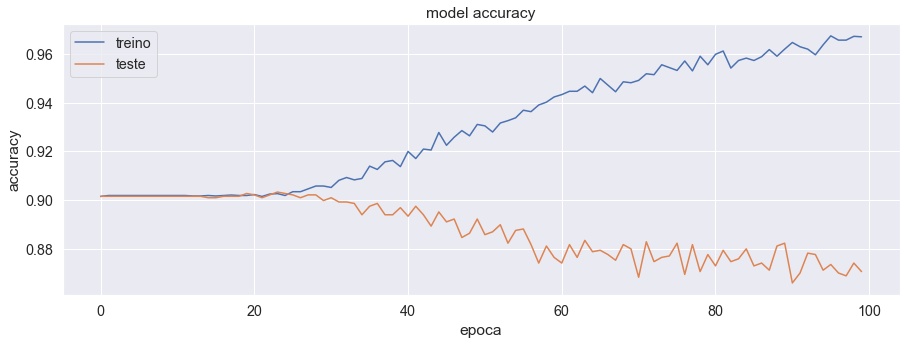

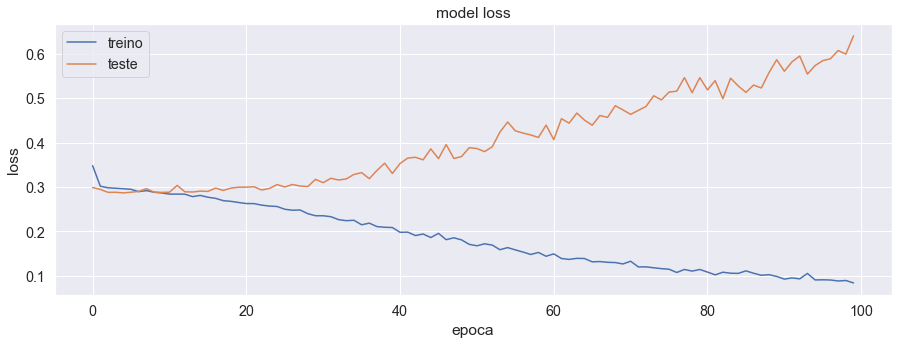

In [120]:
# Loop sobre TODOS os aparelhos (binarios, parametros similares estudo ja feito)
print("Avaliando modelos binários para TODOS os aparelhos, aguarde...")
print()
for aparelho in dados_aparelhos:
    
    print("="*120)
    print()

    y = aparelho["rotulos"]["estado"]

    print(f"* Dados do aparelho `{aparelho['carga'].upper()} - {aparelho['instancia']}` (Y / rótulo:)")
    print("   - ", Counter(y))
    print()

    # Split de treino / teste
    print("* Treinando o modelo classificador de estados...")
    X_treino, X_teste, y_treino, y_teste = train_test_split(
        X_rp, y,
        test_size=.25,
        stratify=y,
        random_state=33
    )

    # Treinando modelo
    modelo = convnet(
        input_shape_= X_rp[0,:,:].shape,
        output_dim = 1,
        loss_function='binary_crossentropy',
        metrics=['accuracy'],
        output_activation='sigmoid'
    )

    historico = modelo.fit(
        X_treino, y_treino,
        validation_data=(X_teste, y_teste),
        epochs=100,
        batch_size=32,
        verbose=0
    )
    print()

    # Avaliando modelo
    relatorio_classificacao_aparelho(modelo, X_teste, y_teste, f'{aparelho["carga"]} - {aparelho["instancia"]}')
    print()